# Notebook to evaluate anomaly scores by unsupervised prediction performance

To run this notebook you need to create and activate the following conda environment:

```
conda create --name score_eval -c conda-forge -c defaults numpy pandas matplotlib seaborn scipy scikit-learn ipython ipykernel -y
conda activate score_eval
pip install -e .
```


## Setup

In [1]:
import os

import numpy as np
import pandas as pd

from src.utils_eval_score import (
    _filter_hosts_w_microbiome_samples_prior_to_abx,
    calculate_matched_metric_n_diff,
    get_scores_n_abx_info,
)
from src.utils_prediction import (
    report_metrics,
    train_n_evaluate_rf_model,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

USER input: define the inferred model and linked datasets to evaluate here:

In [2]:
#### USER INPUT START
# name of the model
model_name = "saved_models_microbial_novel_alpha_div2/id-55"
# which model version to evaluate: "best" or "last"
point_to_evaluate = "best"

# name of feature dataset used for model
ft_name = "ft_vat19_anomaly_v20240806_entero_genus"
# path to abx time-series file
path_to_abx_data = "../data/original_data/"
# name of abx time-series used for model
abx_ts_name = "ts_vat19_abx_v20240806"

# limit evaluation to time range up to this many months (if None no limit is set
# and all scores are evaluated)
limit_months = 24.0

# scaling factor options:
scaling_factors_used = True

# if scaling_factors_used is True, then the following options are required:
# non-centered = "nc_std" or centered = "std"
stddev_type = "nc_std"
# moving average window size: 30 or 10
moving_avg = 10
# whether to include duplicates: "--RD-True" or ""
duplicates = "--RD-False"
# using lower bound of 1 for SFs: "lower_bound-1" or ""
lower_bound = ""

# RF settings
stratify_by_host = True
#### USER INPUT END

## Read and prepare data

In [3]:
base_path = f"../data/{model_name}/anomaly_detection/"

if scaling_factors_used:
    print("Scaling factors used.")
    folder_name = f"using-SF_{stddev_type}_z_scores--moving_avg-{moving_avg}-cummax{lower_bound}{duplicates}"

    scores_path = f"{base_path}scores_{point_to_evaluate}_normal/{folder_name}/"
    evaluation_path = f"{base_path}evaluation_{point_to_evaluate}_unsupervised_pred_{stddev_type}_ma{moving_avg}{duplicates.replace("-", "_").lower()}/"
else:
    scores_path = f"{base_path}scores_{point_to_evaluate}_normal/"
    evaluation_path = f"{base_path}evaluation_{point_to_evaluate}_unsupervised_pred/"

if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)

Scaling factors used.


In [4]:
# get scores
noabx_train, noabx_val, abx_scores_flat, abx_df, abx_age_at_all = get_scores_n_abx_info(
    scores_path, ft_name, limit_months, abx_ts_name
)


## Define true targets

In [5]:
# ensure correct sorting
abx_scores_flat.sort_values(
    [
        "abx_max_count_ever",
        "max_abx_w_microbiome",
        "host_id",
        "day",
    ],
    ascending=[True, True, True, True],
    inplace=True,
)

In [6]:
# filter abx hosts by at least 1 microbiome sample prior to 1st abx exposure
print(abx_scores_flat.shape)
abx_scores_flat_f = _filter_hosts_w_microbiome_samples_prior_to_abx(
    abx_scores_flat, abx_age_at_all
)
abx_scores_flat_f.shape

(998, 21)
Number of hosts with 1st abx exposure prior to 1st microbiome sample:             34
Number of hosts w microbiome sample prior to 1st abx exposure:             106


(831, 21)

In [7]:
# get sample count per host:
abx_scores_flat_f["sample_count"] = abx_scores_flat_f.groupby("host_id").cumcount() + 1


In [8]:
abx_scores_flat_f["true_target"] = np.nan

# ! define true positives: 1st observed sample in first 1-3 months after 1st abx exposure
# select samples in first 3 months after 1st abx exposure
# * 1st abx exposure: abx_scores_flat_f["abx_any_cumcount"] == 1
# * any abx exposure: abx_scores_flat_f["abx_any_cumcount"] > 0
samples_after_1st = (abx_scores_flat_f["abx_any_cumcount"] == 1) & (
    abx_scores_flat_f["abx_any_last_t_dmonths"] <= 3.0
)

# identify first sample after 1st abx exposure per host
first_sample_idx = (
    abx_scores_flat_f[samples_after_1st]
    .groupby("host_id")["abx_any_last_t_dmonths"]
    .idxmin()
)
# * any sample after abx: use samples_after_1st directly instead of first_sample_idx

# Set 'true_target' to True for these samples
abx_scores_flat_f.loc[first_sample_idx, "true_target"] = 1

# ! define true negatives: samples with abx_cumcount == 0 & at least one
# sample prior to that (for consistency with true positives definition)
true_negative_cond = (abx_scores_flat_f["abx_any_cumcount"] == 0) & (
    abx_scores_flat_f["sample_count"] > 1
)
abx_scores_flat_f.loc[true_negative_cond, "true_target"] = 0

abx_scores_flat_f["true_target"].value_counts(dropna=False)


true_target
NaN    514
0.0    247
1.0     70
Name: count, dtype: int64

In [9]:
# select only samples with true_target
unsupervised_subset = abx_scores_flat_f[abx_scores_flat_f["true_target"].notna()].copy()
print(unsupervised_subset["true_target"].value_counts(dropna=False))
unsupervised_subset.shape

true_target
0.0    247
1.0     70
Name: count, dtype: int64


(317, 23)

## Define features needed for modelling

In [10]:
# get noabx matched alpha diversity values - needed for baseline comparisons
noabx = pd.concat([noabx_train, noabx_val])

metric = "div_alpha_faith_pd"
matching_vars = ["month_bin", "delivery_mode", "diet_milk", "diet_weaning"]
unsupervised_subset = calculate_matched_metric_n_diff(
    metric, unsupervised_subset, noabx, matching_vars
)
# f"diff_2_matched_{metric}"

# * note: 2 negative targets are disregarded in B1 + B2 comparisons because
# there is no reference in noabx for them
unsupervised_subset.loc[
    unsupervised_subset[f"diff_2_matched_{metric}"].isna(), "true_target"
]

Number of samples disregarded because of lacking reference in noabx: 2


96     0.0
310    0.0
Name: true_target, dtype: float64

In [11]:
# get relative increase in metrics from one step to the next and time
# duration between scores
unsupervised_subset = (
    unsupervised_subset.groupby("host_id")
    .apply(
        lambda x: x.assign(
            # relative score increase: now / previous
            score_0_rel_change=x["score_0"] / x["score_0"].shift(1),
            # relative matched alpha diversity difference increase: now / previous
            diff_2_matched_div_alpha_faith_pd_rel_change=x[f"diff_2_matched_{metric}"]
            / x[f"diff_2_matched_{metric}"].shift(1),
            # diff in time between samples:
            month5_bin_diff=x["month5_bin"].diff(),
            # former alpha diversity value
            div_alpha_faith_pd_before=x["div_alpha_faith_pd"].shift(1),
        ),
        include_groups=False,
    )
    .reset_index()
)


## Score-based predictions

### S1: Set absolute threshold

Quantile: 0.99
              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87       247
         1.0       0.00      0.00      0.00        70

    accuracy                           0.77       317
   macro avg       0.39      0.49      0.43       317
weighted avg       0.60      0.77      0.68       317



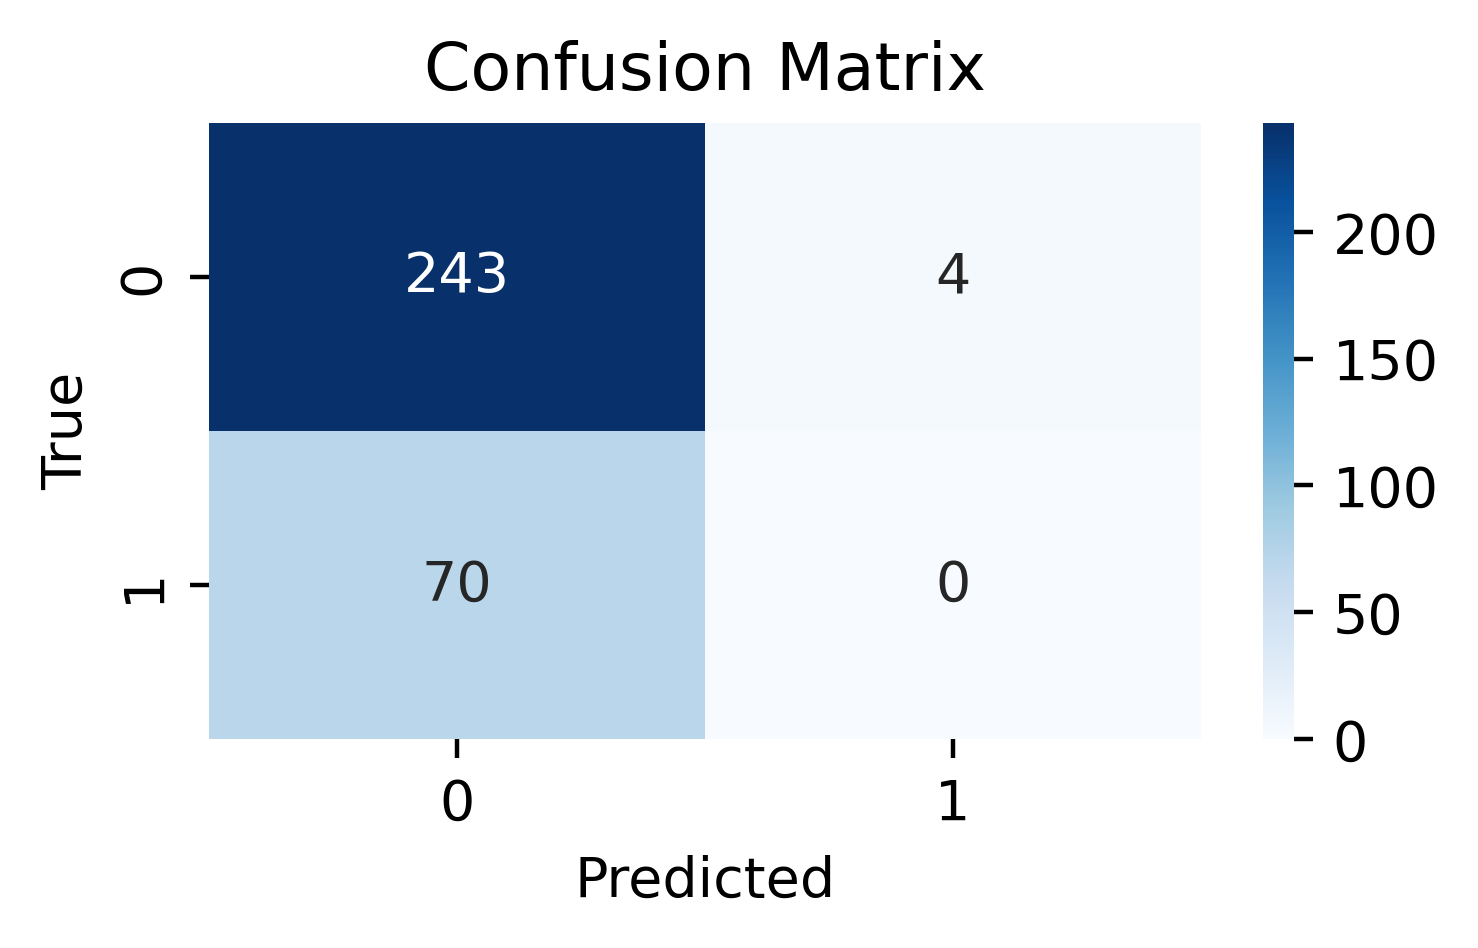

Quantile: 0.97
              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86       247
         1.0       0.29      0.06      0.10        70

    accuracy                           0.76       317
   macro avg       0.53      0.51      0.48       317
weighted avg       0.67      0.76      0.69       317



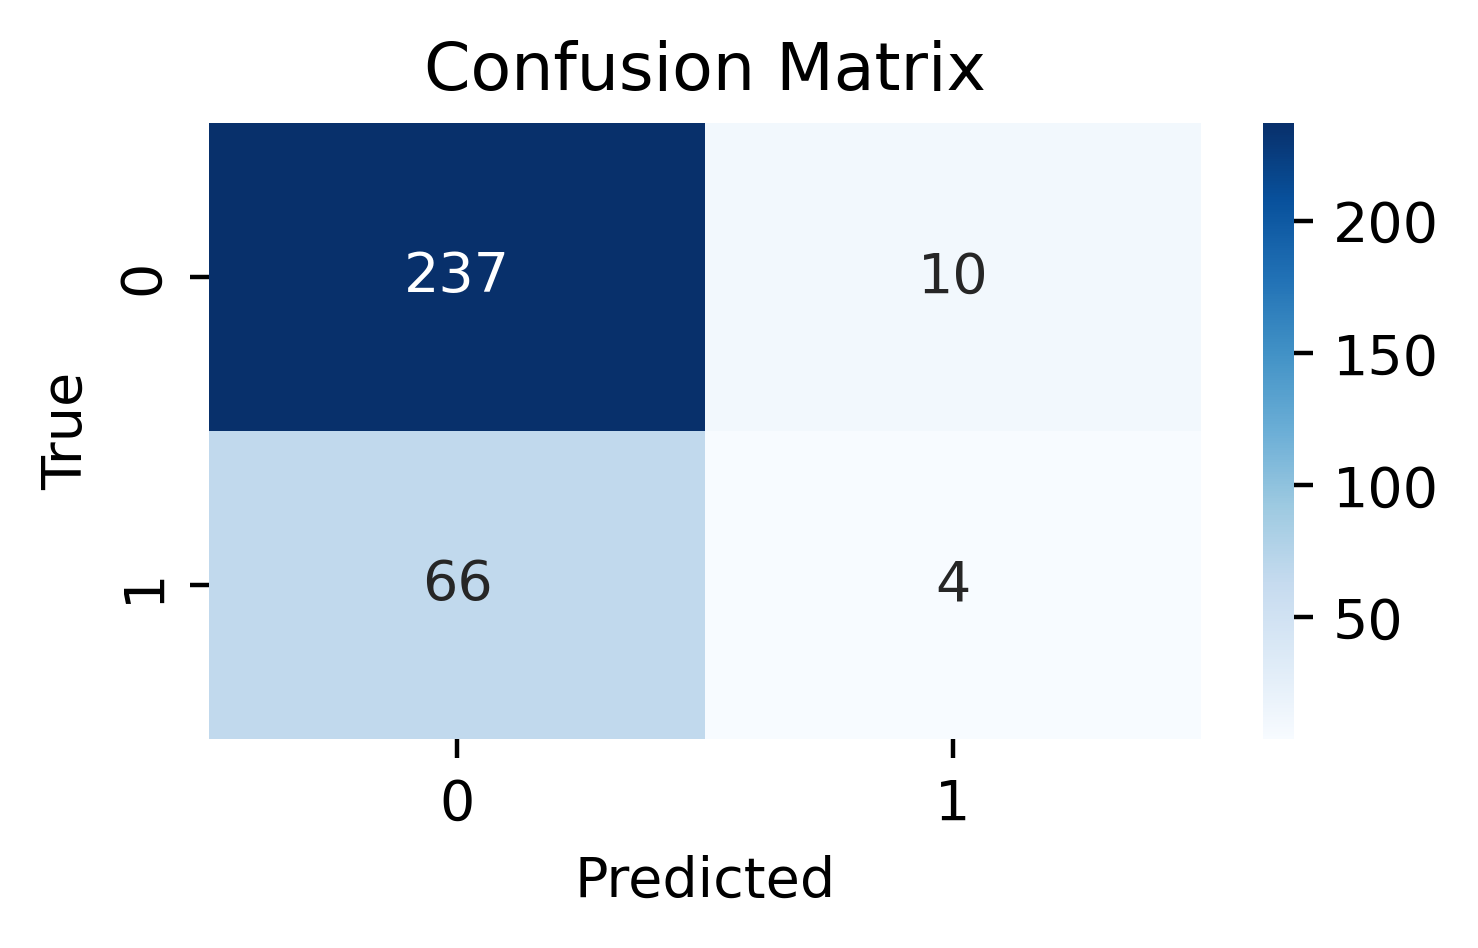

Quantile: 0.95
              precision    recall  f1-score   support

         0.0       0.79      0.94      0.86       247
         1.0       0.32      0.10      0.15        70

    accuracy                           0.75       317
   macro avg       0.55      0.52      0.50       317
weighted avg       0.68      0.75      0.70       317



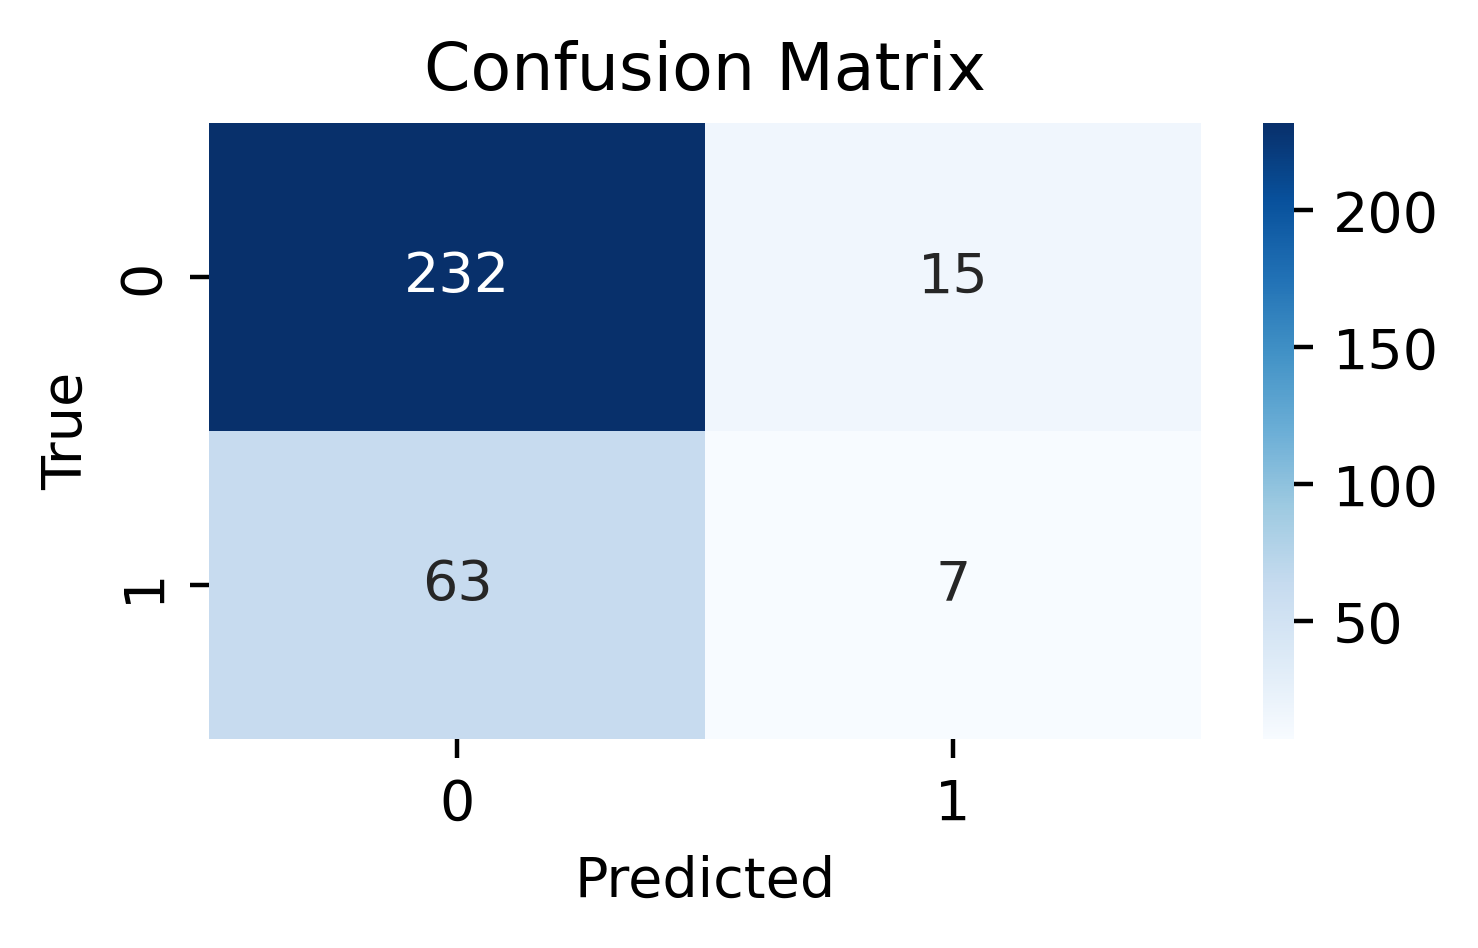

Quantile: 0.9
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       247
         1.0       0.28      0.16      0.20        70

    accuracy                           0.72       317
   macro avg       0.53      0.52      0.52       317
weighted avg       0.67      0.72      0.69       317



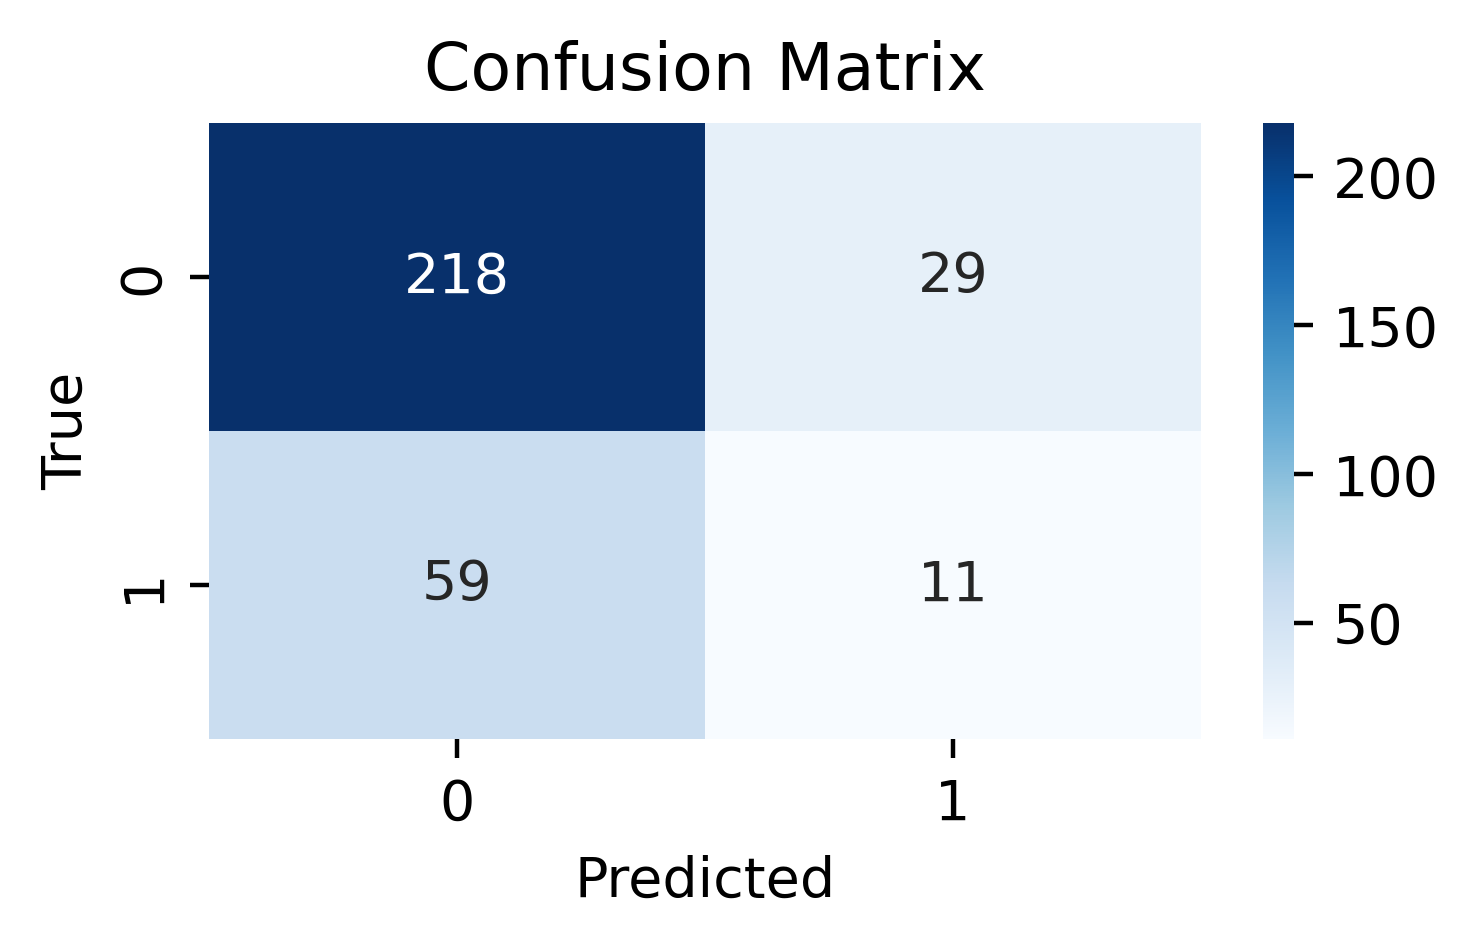

Quantile: 0.8
              precision    recall  f1-score   support

         0.0       0.81      0.76      0.78       247
         1.0       0.30      0.37      0.33        70

    accuracy                           0.67       317
   macro avg       0.56      0.56      0.56       317
weighted avg       0.70      0.67      0.68       317



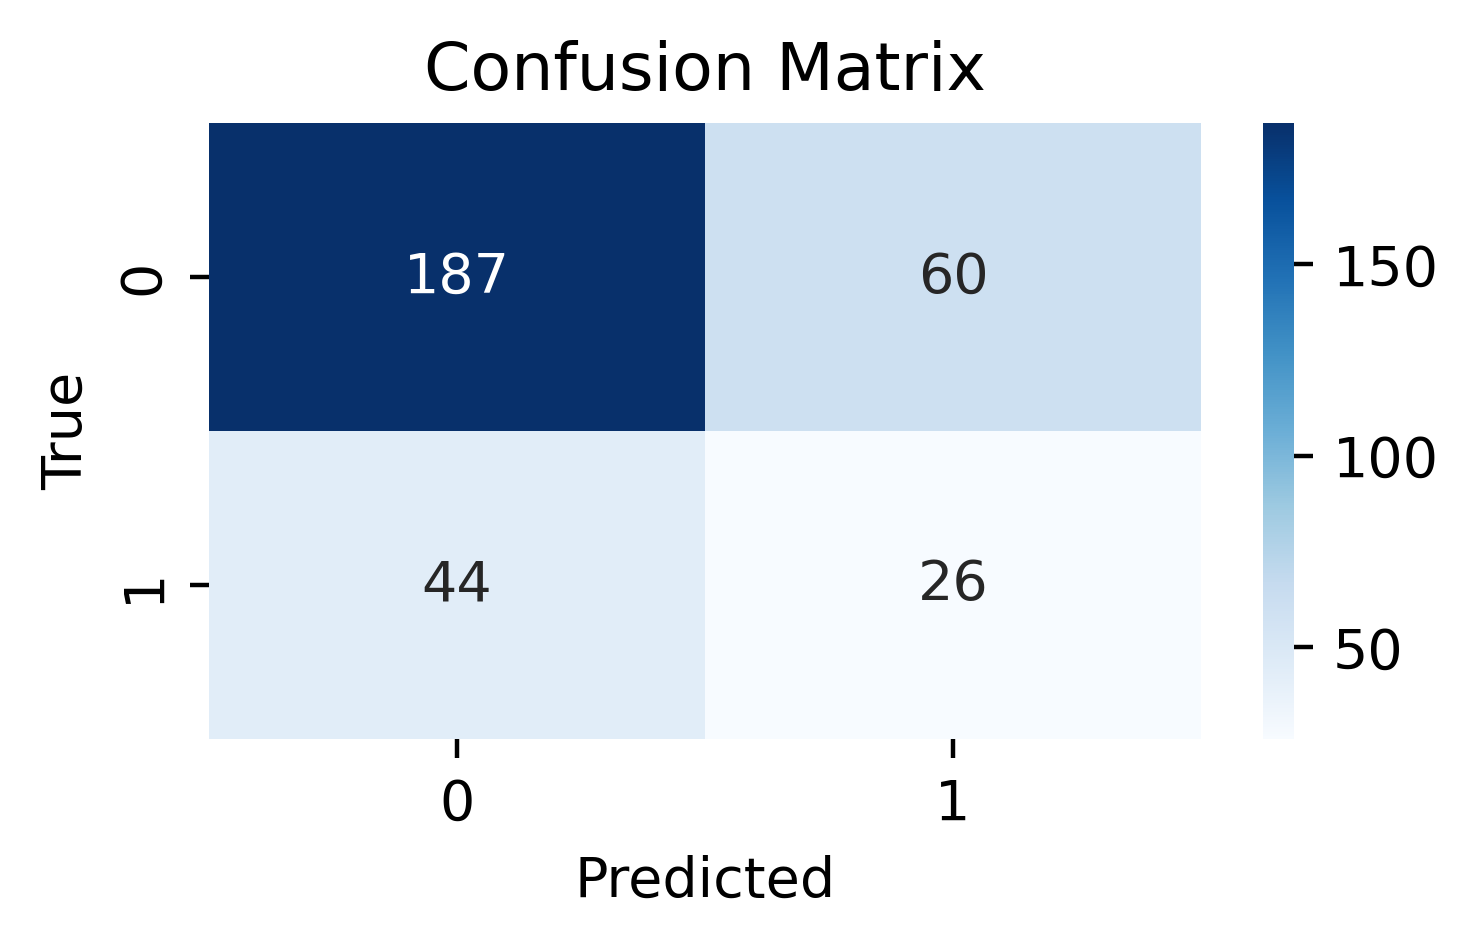

Quantile: 0.7
              precision    recall  f1-score   support

         0.0       0.80      0.62      0.70       247
         1.0       0.25      0.44      0.32        70

    accuracy                           0.58       317
   macro avg       0.52      0.53      0.51       317
weighted avg       0.68      0.58      0.61       317



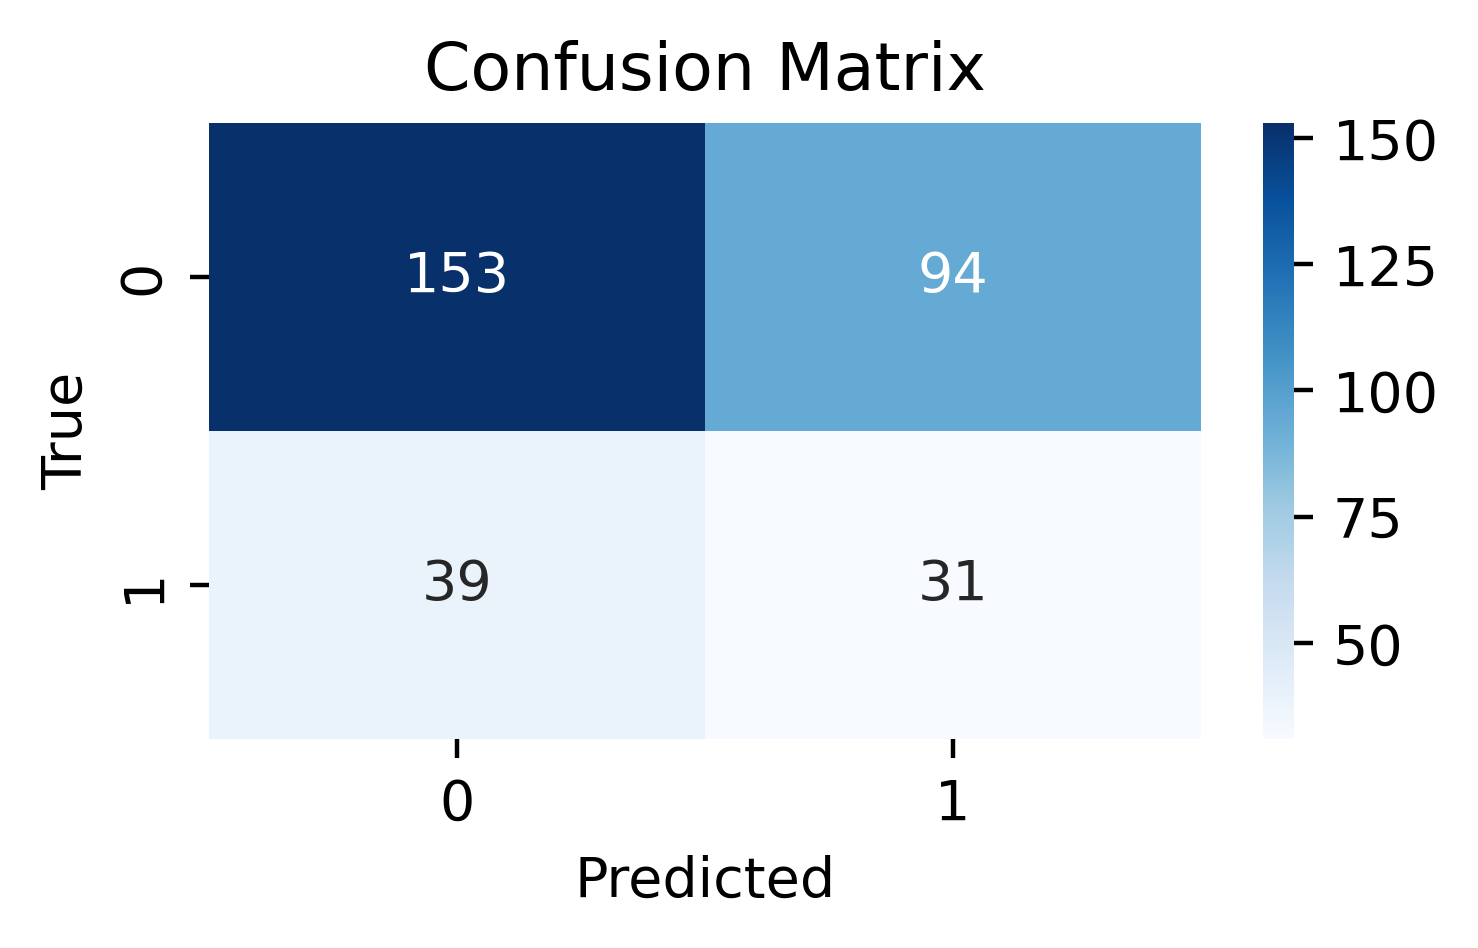

,weighted_avg_f1,macro_avg_f1,true_f1_score,accuracy,MCC,model_run
quantile,,,,,,
0.99,0.676217,0.433929,0.000000,0.766562,-0.060181,s1_absolute
0.97,0.692542,0.478528,0.095238,0.760252,0.033629,s1_absolute
0.95,0.700650,0.504131,0.152174,0.753943,0.064099,s1_absolute
0.90,0.692489,0.516031,0.200000,0.722397,0.049635,s1_absolute
0.80,0.683258,0.557880,0.333333,0.671924,0.119892,s1_absolute
0.70,0.613328,0.507494,0.317949,0.580442,0.052870,s1_absolute


In [12]:
df_results_absolute = pd.DataFrame()
df_results_absolute.index.name = "quantile"

for q in reversed([0.7, 0.8, 0.9, 0.95, 0.97, 0.99]):
    unsupervised_subset_th = unsupervised_subset.copy()

    # define predicted target: threshold inferred from noabx validation set
    print(f"Quantile: {q}")
    thresh = noabx_val["score_0"].quantile(q)
    unsupervised_subset_th["pred_target"] = unsupervised_subset_th["score_0"] > thresh

    # evaluate classification
    df_results_absolute = report_metrics(
        unsupervised_subset_th["true_target"],
        unsupervised_subset_th["pred_target"],
        df_results_absolute,
        q,
    )
df_results_absolute["model_run"] = "s1_absolute"
df_results_absolute

### S2: Set relative score increase

Relative increase: 1.05
              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72       247
         1.0       0.19      0.26      0.22        70

    accuracy                           0.59       317
   macro avg       0.48      0.47      0.47       317
weighted avg       0.64      0.59      0.61       317



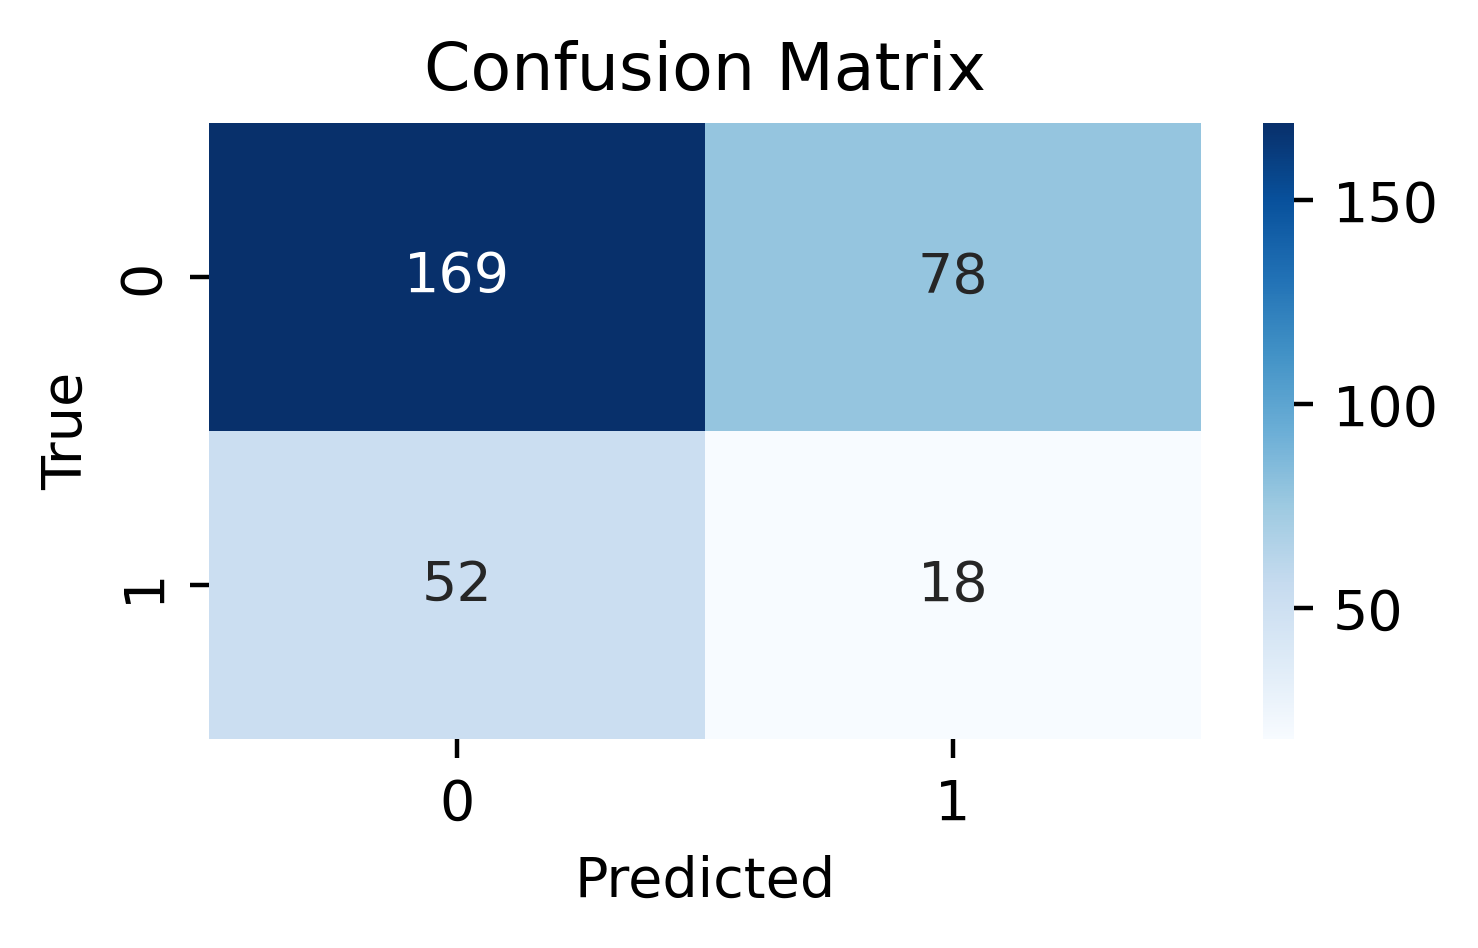

Relative increase: 1.1
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74       247
         1.0       0.20      0.26      0.23        70

    accuracy                           0.61       317
   macro avg       0.49      0.48      0.48       317
weighted avg       0.64      0.61      0.63       317



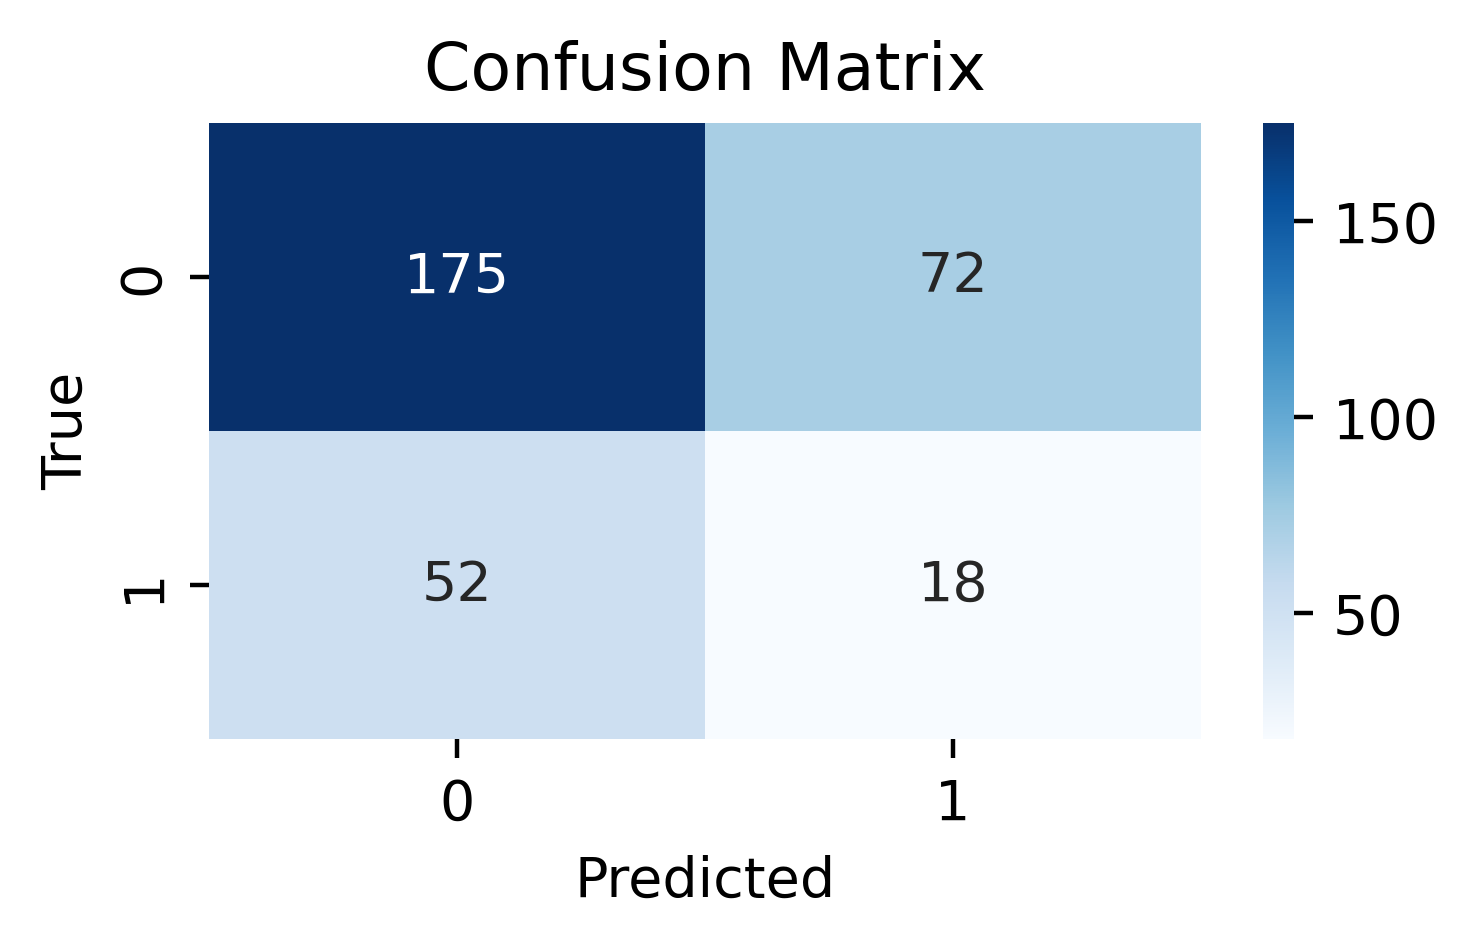

Relative increase: 1.2
              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75       247
         1.0       0.20      0.23      0.21        70

    accuracy                           0.62       317
   macro avg       0.48      0.48      0.48       317
weighted avg       0.64      0.62      0.63       317



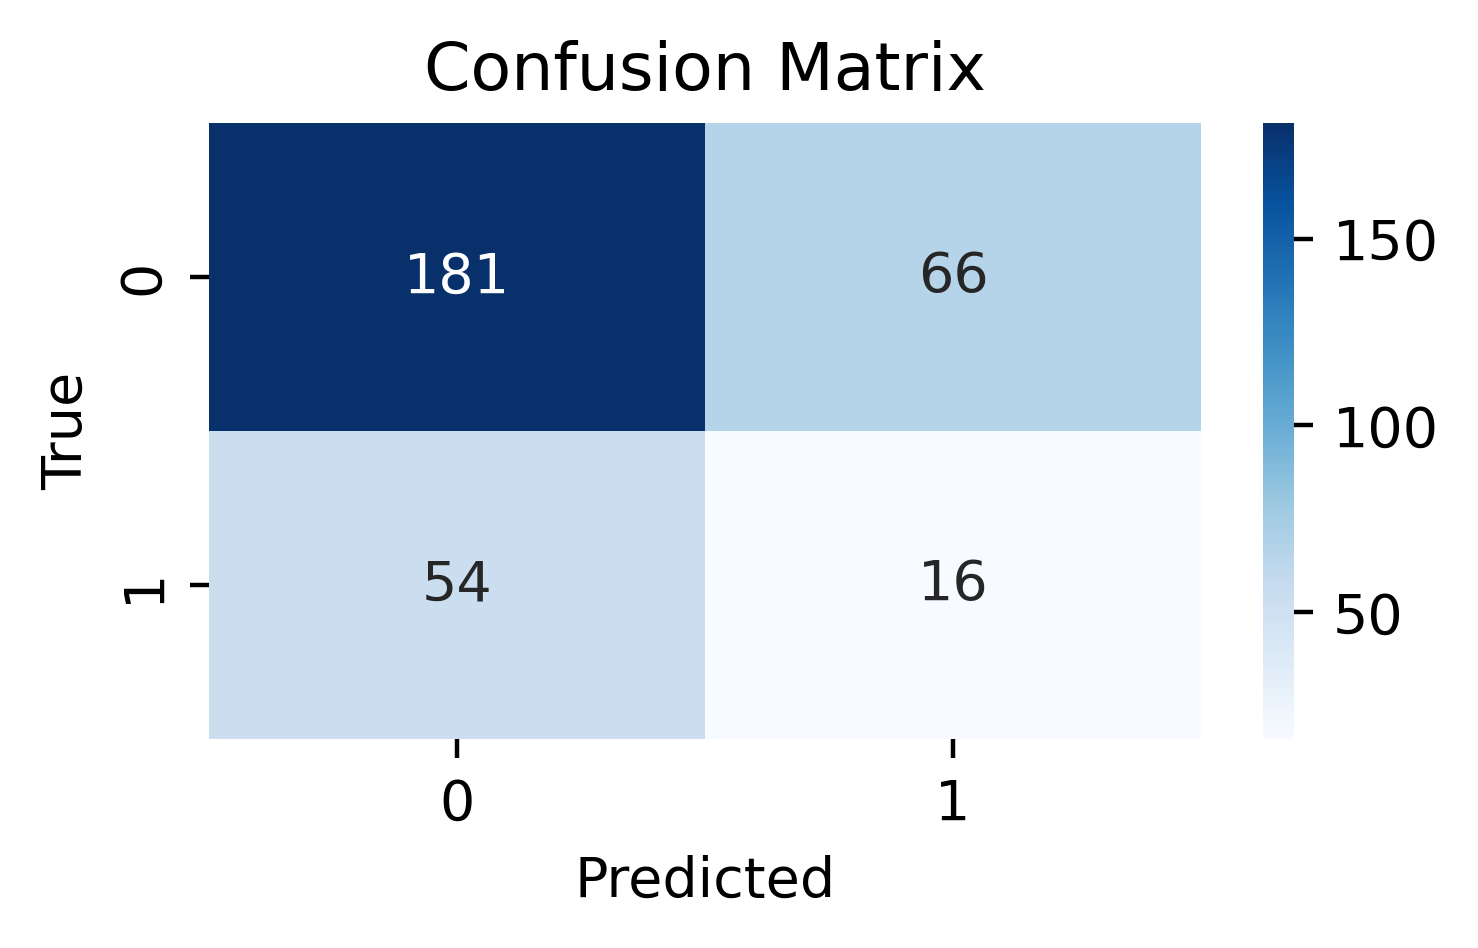

Relative increase: 1.3
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.75       247
         1.0       0.19      0.21      0.20        70

    accuracy                           0.62       317
   macro avg       0.48      0.48      0.48       317
weighted avg       0.64      0.62      0.63       317



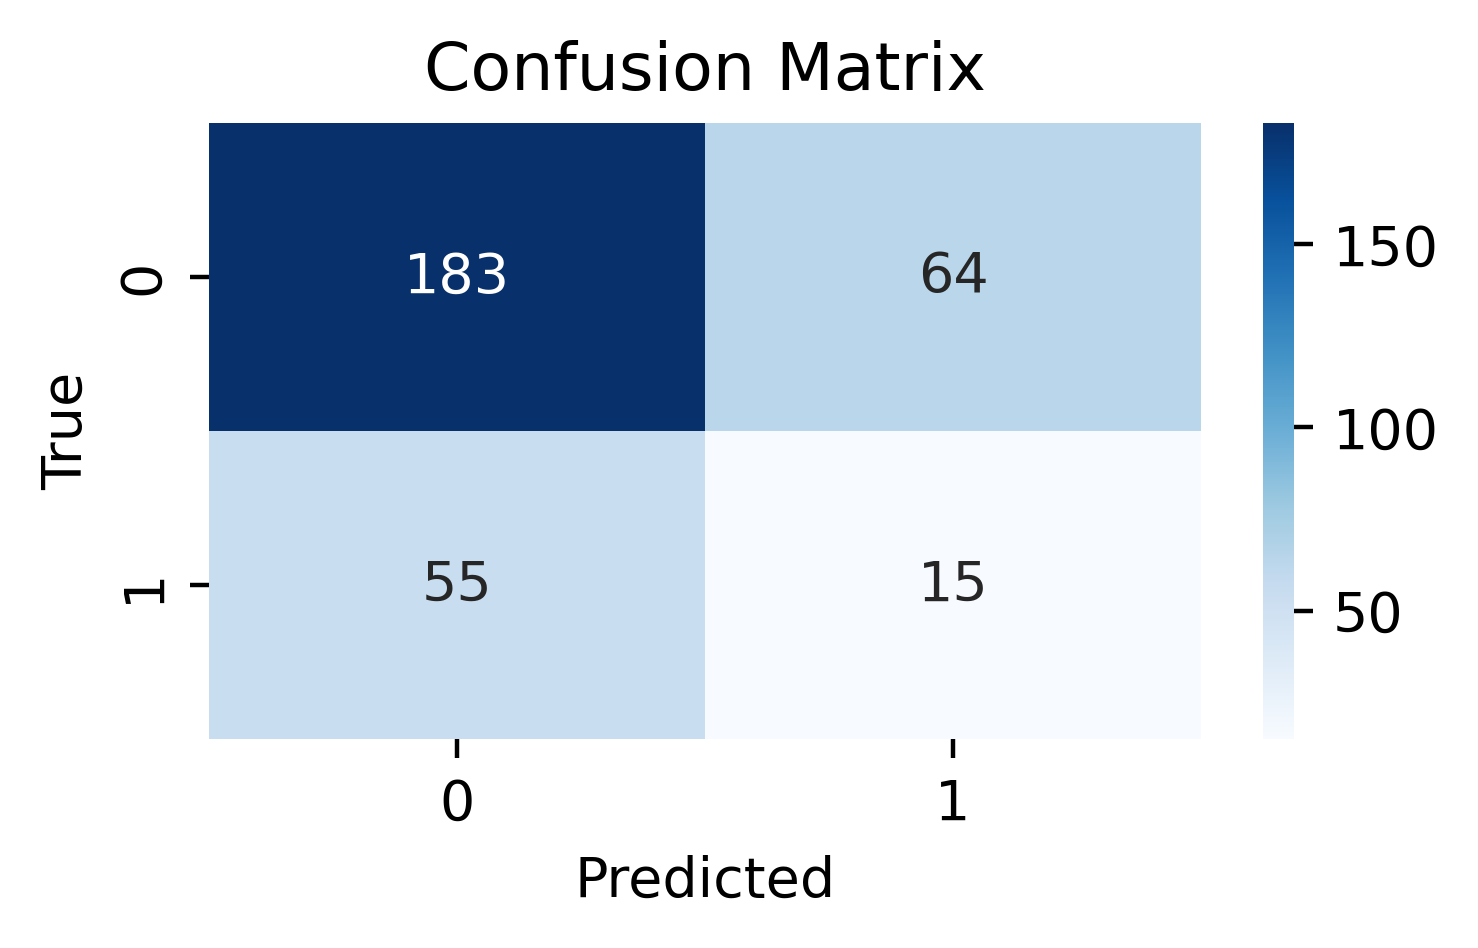

Relative increase: 1.4
              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76       247
         1.0       0.18      0.20      0.19        70

    accuracy                           0.62       317
   macro avg       0.47      0.47      0.47       317
weighted avg       0.64      0.62      0.63       317



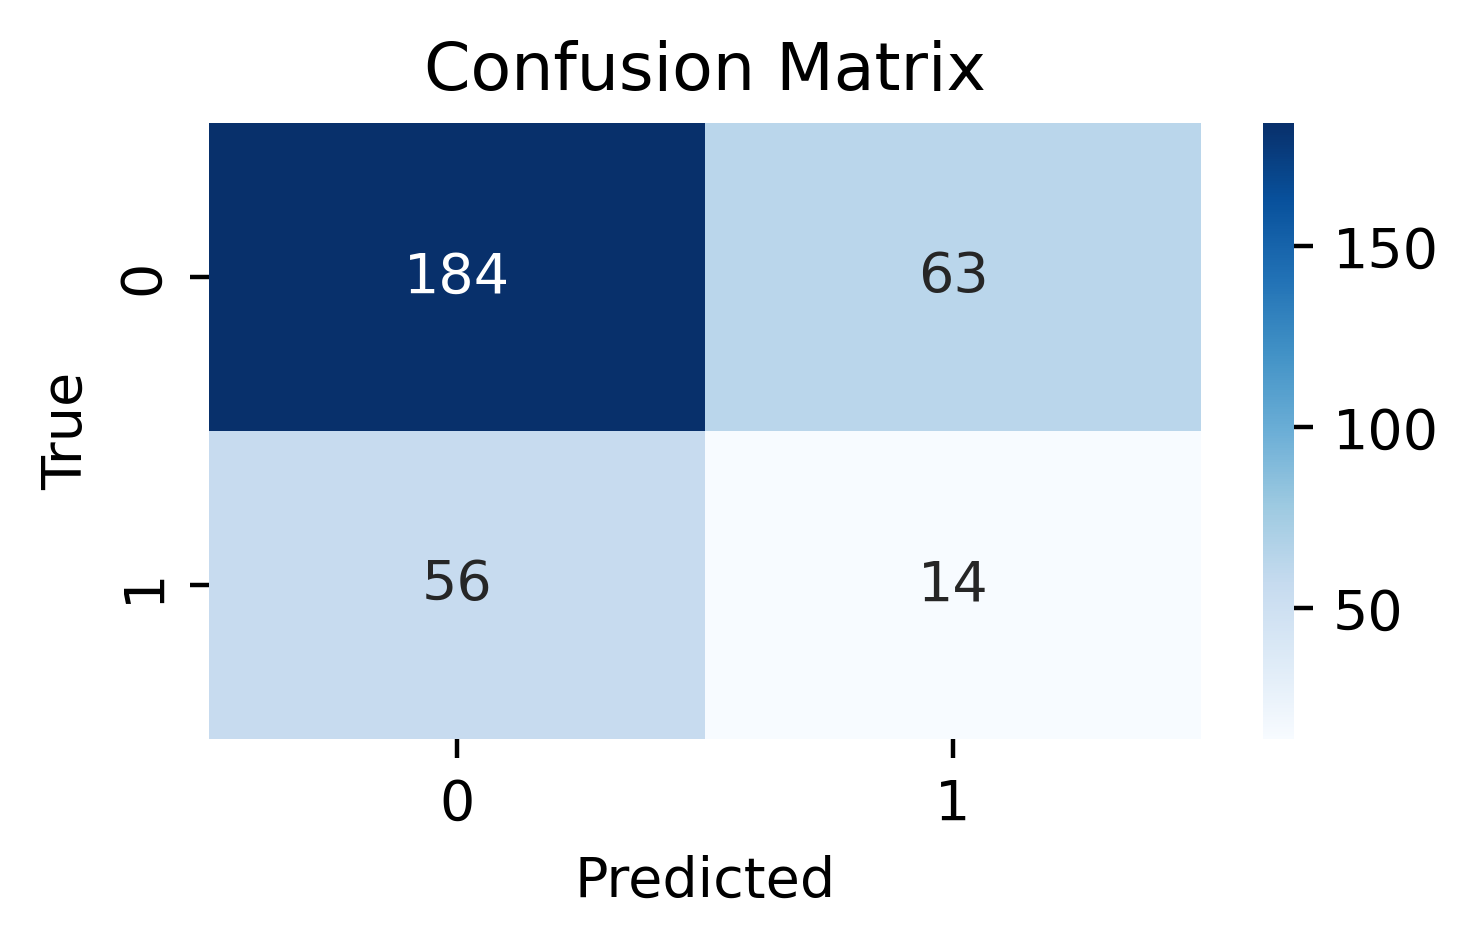

Relative increase: 1.5
              precision    recall  f1-score   support

         0.0       0.77      0.76      0.76       247
         1.0       0.18      0.19      0.18        70

    accuracy                           0.63       317
   macro avg       0.47      0.47      0.47       317
weighted avg       0.64      0.63      0.63       317



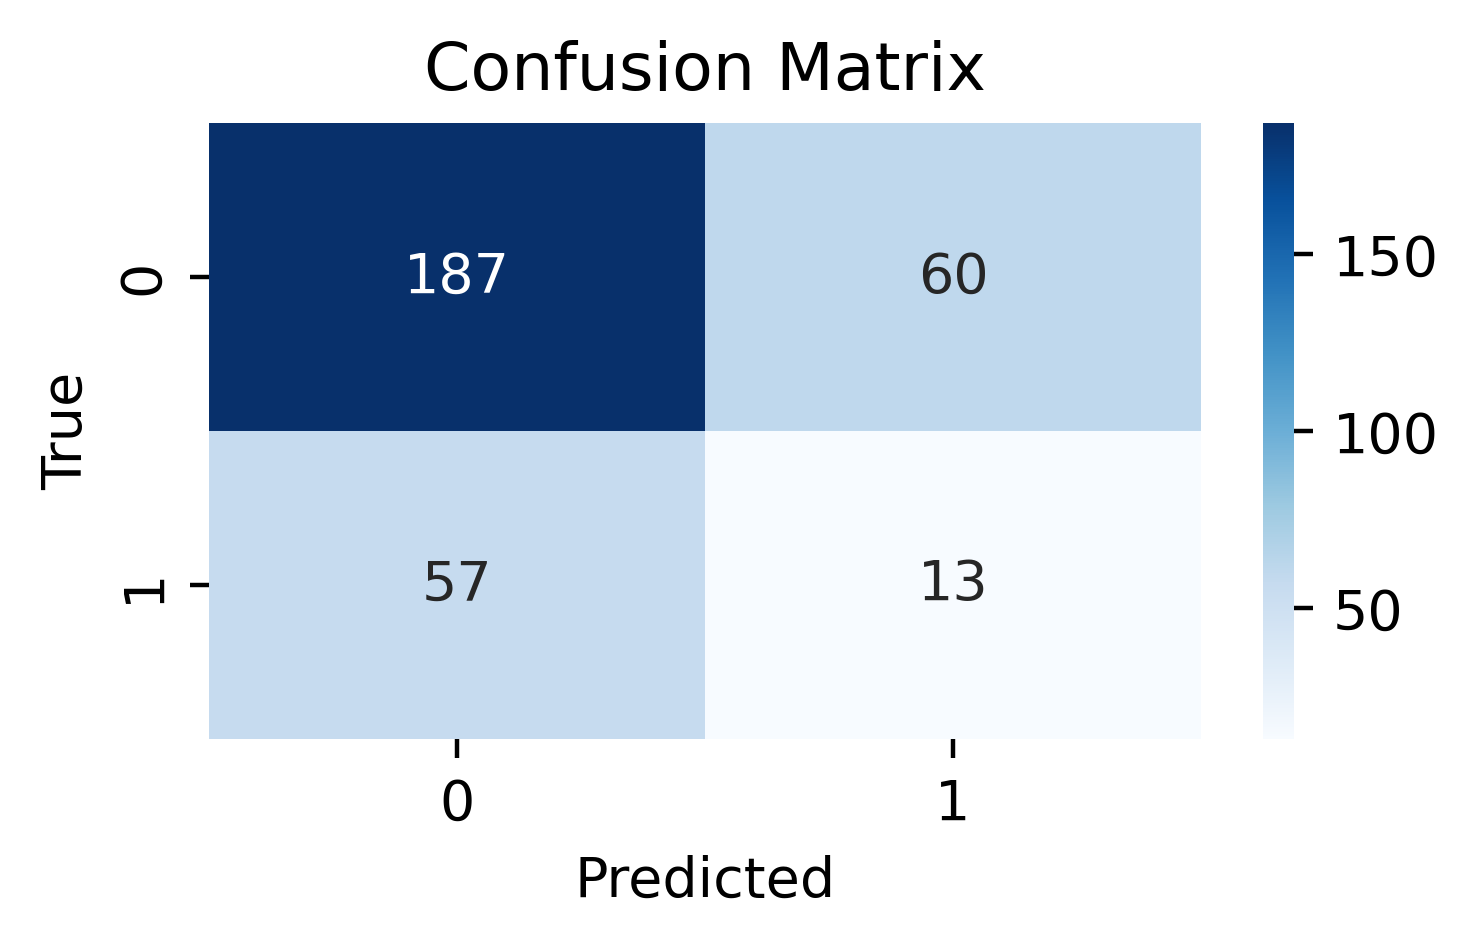

Relative increase: 1.75
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78       247
         1.0       0.19      0.17      0.18        70

    accuracy                           0.65       317
   macro avg       0.48      0.48      0.48       317
weighted avg       0.64      0.65      0.65       317



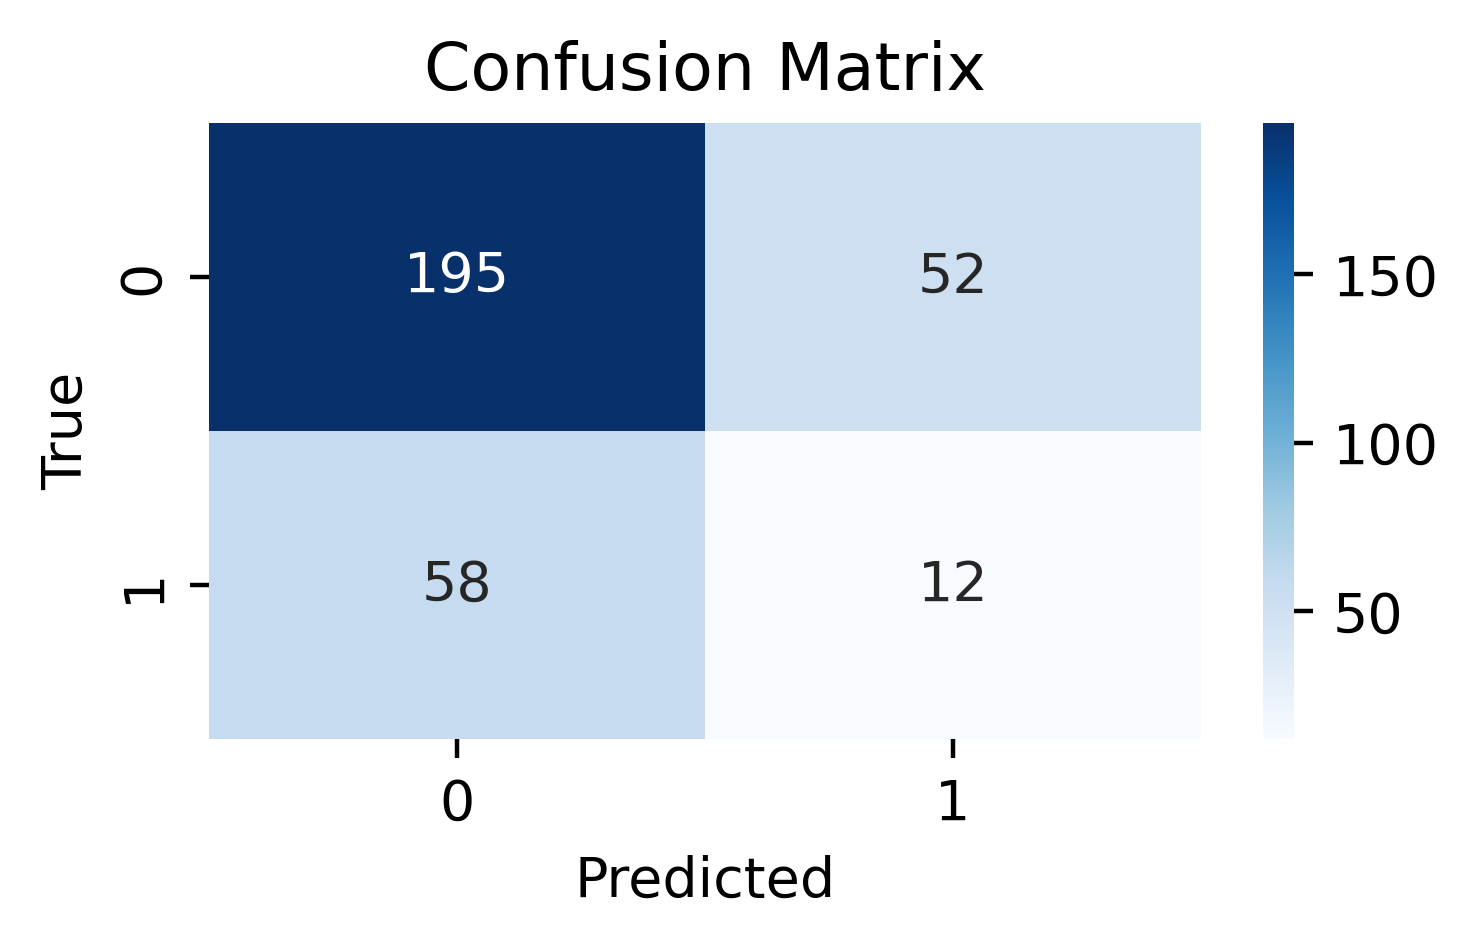

Relative increase: 2.0
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79       247
         1.0       0.21      0.17      0.19        70

    accuracy                           0.67       317
   macro avg       0.49      0.49      0.49       317
weighted avg       0.65      0.67      0.66       317



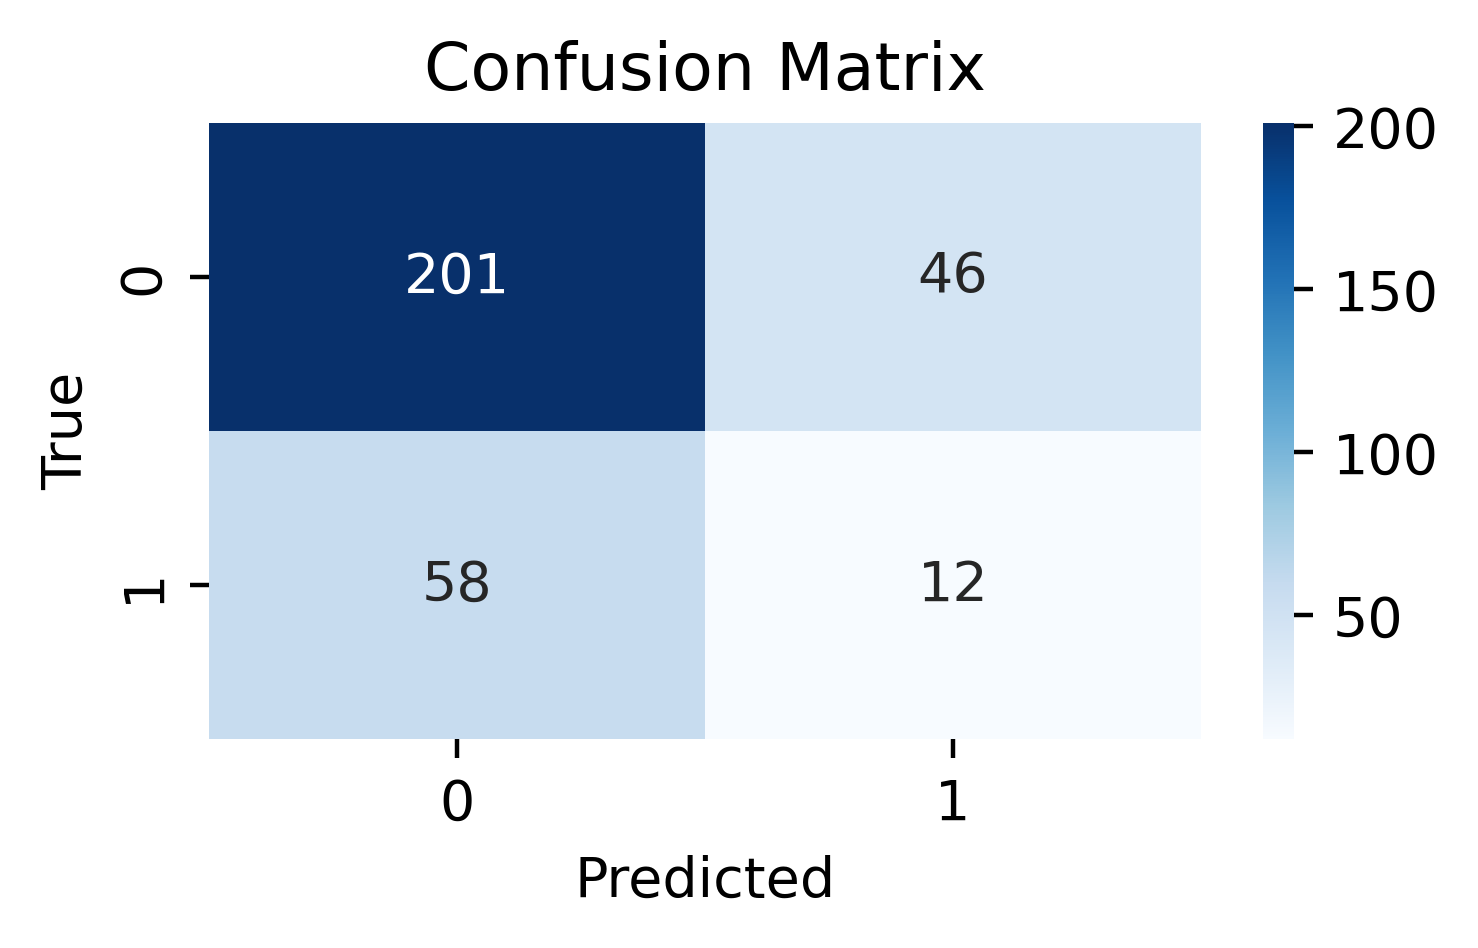

Relative increase: 3
              precision    recall  f1-score   support

         0.0       0.78      0.87      0.82       247
         1.0       0.21      0.11      0.15        70

    accuracy                           0.71       317
   macro avg       0.49      0.49      0.48       317
weighted avg       0.65      0.71      0.67       317



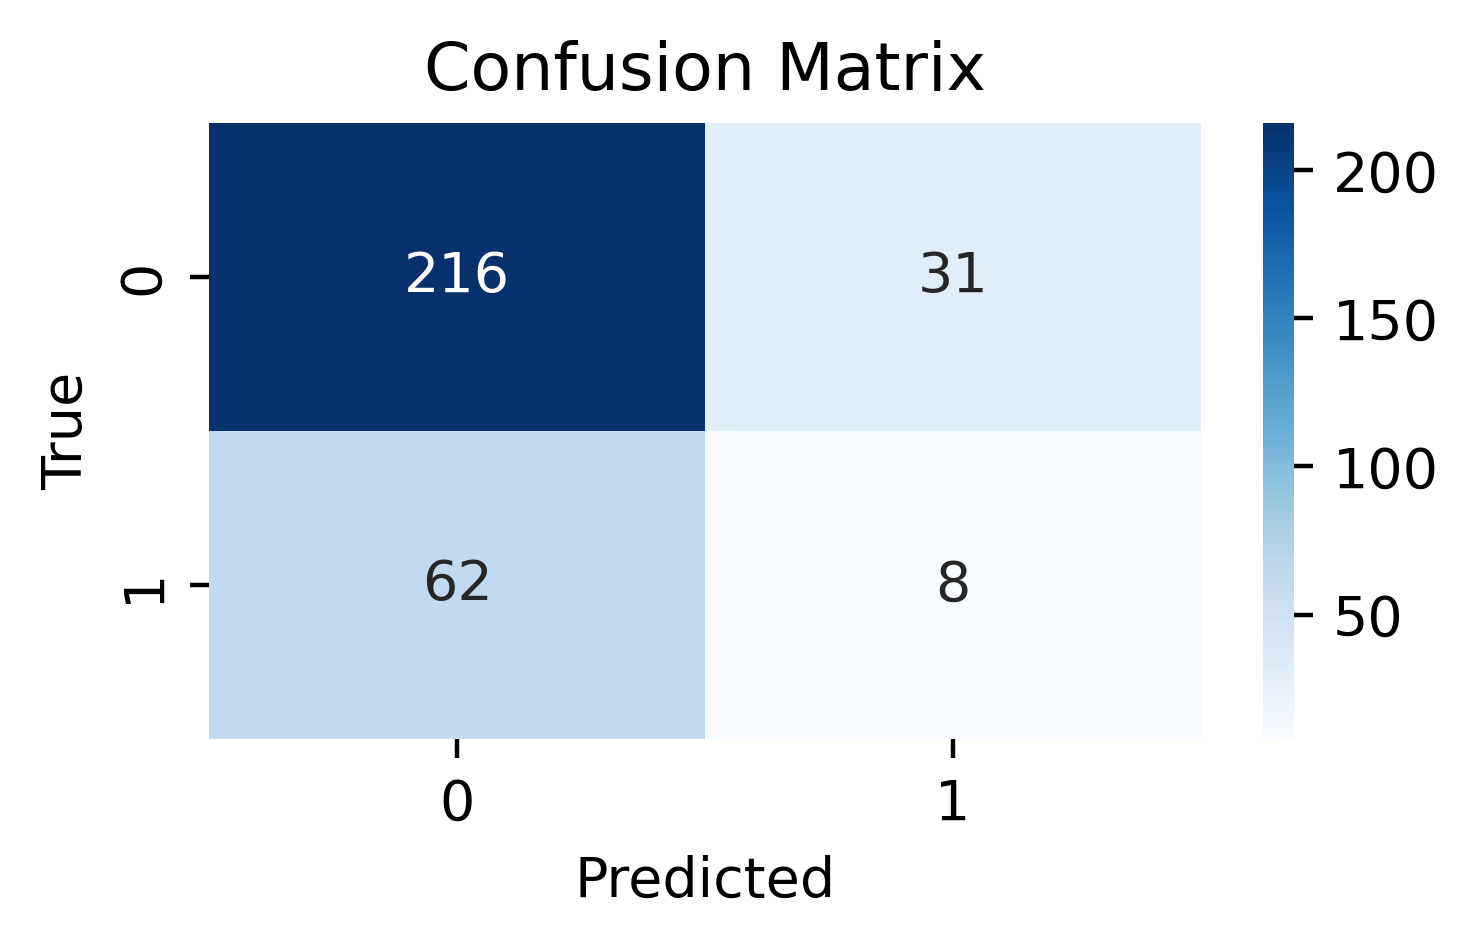

Relative increase: 4
              precision    recall  f1-score   support

         0.0       0.78      0.92      0.85       247
         1.0       0.24      0.09      0.13        70

    accuracy                           0.74       317
   macro avg       0.51      0.50      0.49       317
weighted avg       0.66      0.74      0.69       317



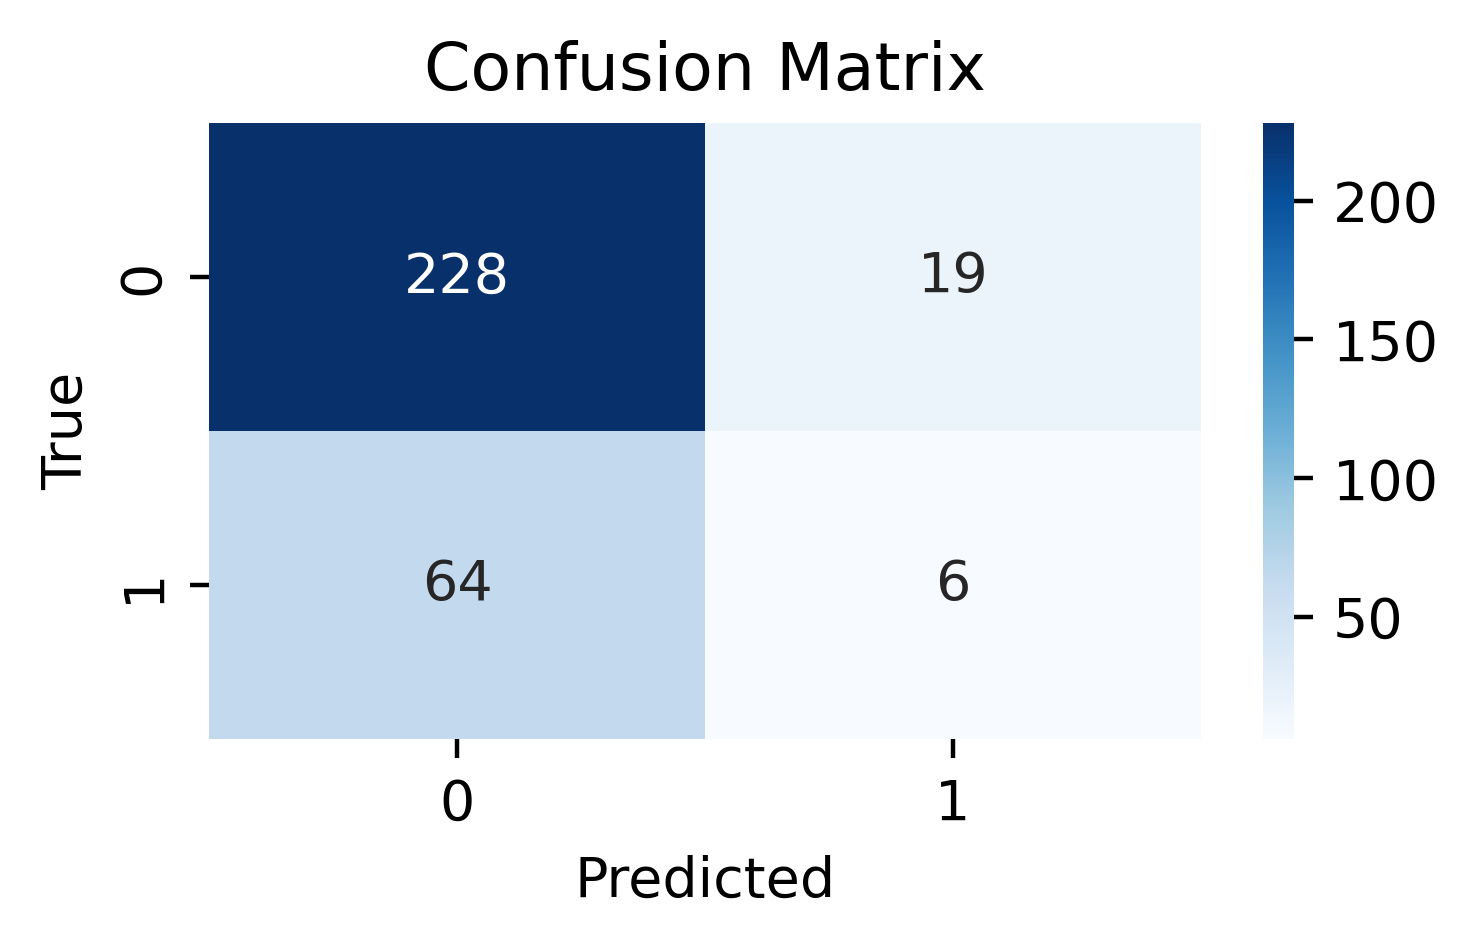

,weighted_avg_f1,macro_avg_f1,true_f1_score,accuracy,MCC,model_run
rel_increase,,,,,,
1.05,0.610630,0.469545,0.216867,0.589905,-0.052943,s2_relative
1.10,0.625028,0.481698,0.225000,0.608833,-0.031605,s2_relative
1.20,0.631682,0.480782,0.210526,0.621451,-0.036596,s2_relative
1.30,0.632460,0.477991,0.201342,0.624606,-0.042984,s2_relative
1.40,0.630846,0.473062,0.190476,0.624606,-0.053258,s2_relative
1.50,0.633659,0.471764,0.181818,0.630915,-0.056356,s2_relative
1.75,0.647310,0.479552,0.179104,0.652997,-0.040402,s2_relative
2.00,0.660436,0.490983,0.187500,0.671924,-0.015885,s2_relative
3.00,0.673568,0.484823,0.146789,0.706625,-0.014169,s2_relative


In [13]:
df_results_relative = pd.DataFrame()
df_results_relative.index.name = "rel_increase"

for rel_inc in reversed([4, 3, 2.0, 1.75, 1.5, 1.4, 1.3, 1.2, 1.1, 1.05]):
    unsupervised_subset_rel = unsupervised_subset.copy()

    # define predicted target: rel_inc-ing of score within 3 months
    print(f"Relative increase: {rel_inc}")

    unsupervised_subset_rel["pred_target"] = 0

    pred_true = (unsupervised_subset_rel["score_0_rel_change"] >= rel_inc) & (
        unsupervised_subset_rel["month5_bin_diff"] <= 3.0
    )
    unsupervised_subset_rel.loc[pred_true, "pred_target"] = 1

    # evaluate classification
    df_results_relative = report_metrics(
        unsupervised_subset_rel["true_target"],
        unsupervised_subset_rel["pred_target"],
        df_results_relative,
        rel_inc,
    )
df_results_relative["model_run"] = "s2_relative"
df_results_relative

### S3: RF-based classifier

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82        89
         1.0       0.25      0.23      0.24        22

    accuracy                           0.71       111
   macro avg       0.53      0.53      0.53       111
weighted avg       0.70      0.71      0.71       111



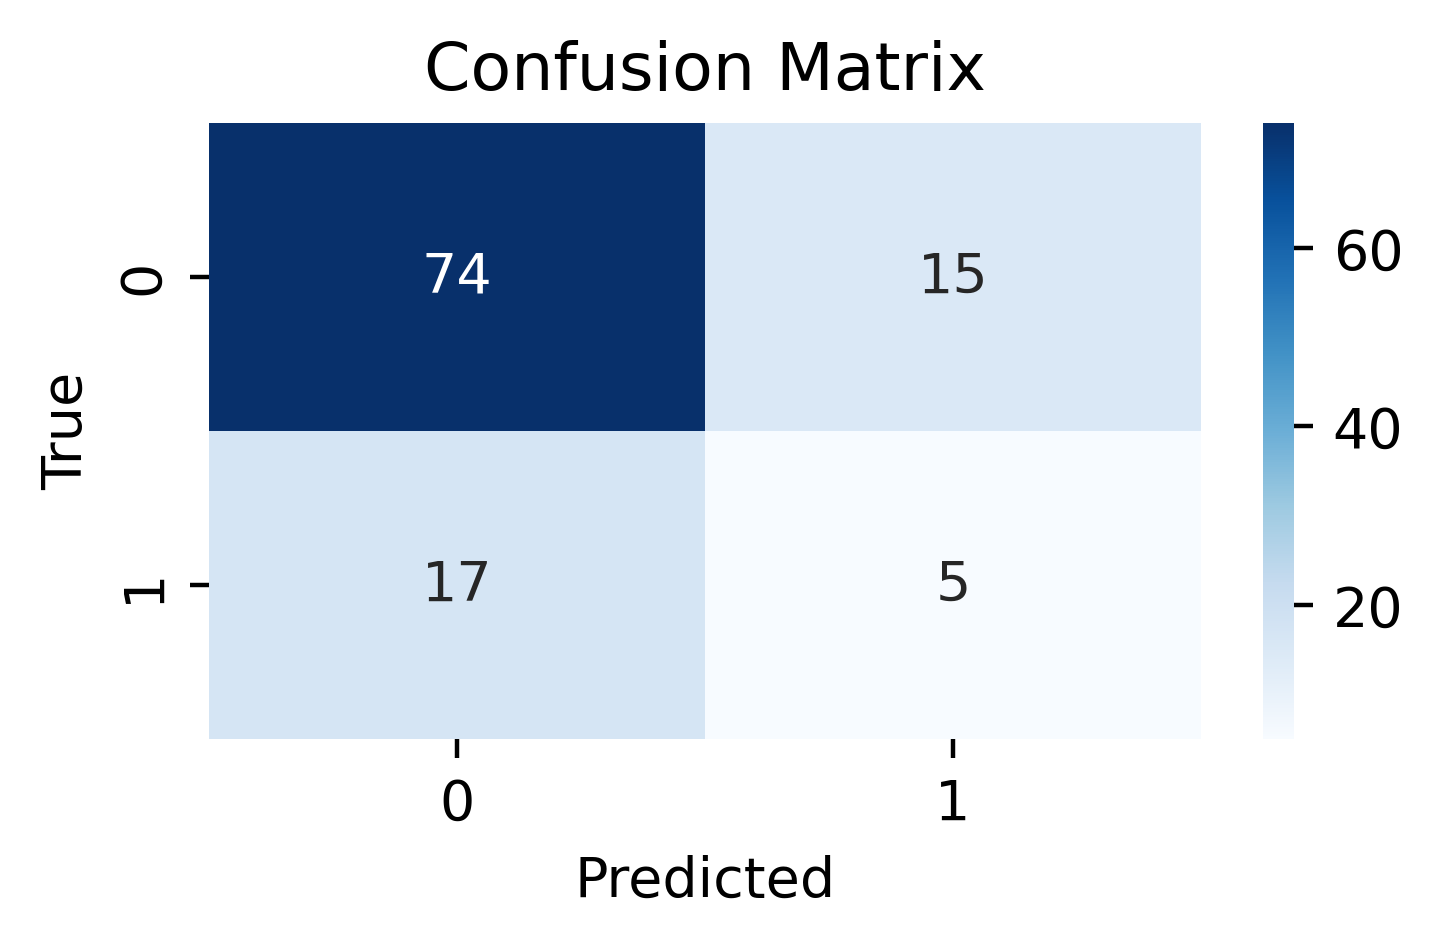

,weighted_avg_f1,macro_avg_f1,true_f1_score,accuracy,MCC,model_run
RF,0.706449,0.530159,0.238095,0.711712,0.060919,s3_ml


In [14]:
df_results_ml = train_n_evaluate_rf_model(
    "true_target", ["score_0"], unsupervised_subset, stratify_split=stratify_by_host
)
df_results_ml["model_run"] = "s3_ml"
df_results_ml

## Baseline predictions

### B1: Set absolute threshold for difference to matched diversity

7
              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84       247
         1.0       0.24      0.11      0.16        70

    accuracy                           0.73       317
   macro avg       0.51      0.51      0.50       317
weighted avg       0.66      0.73      0.69       317



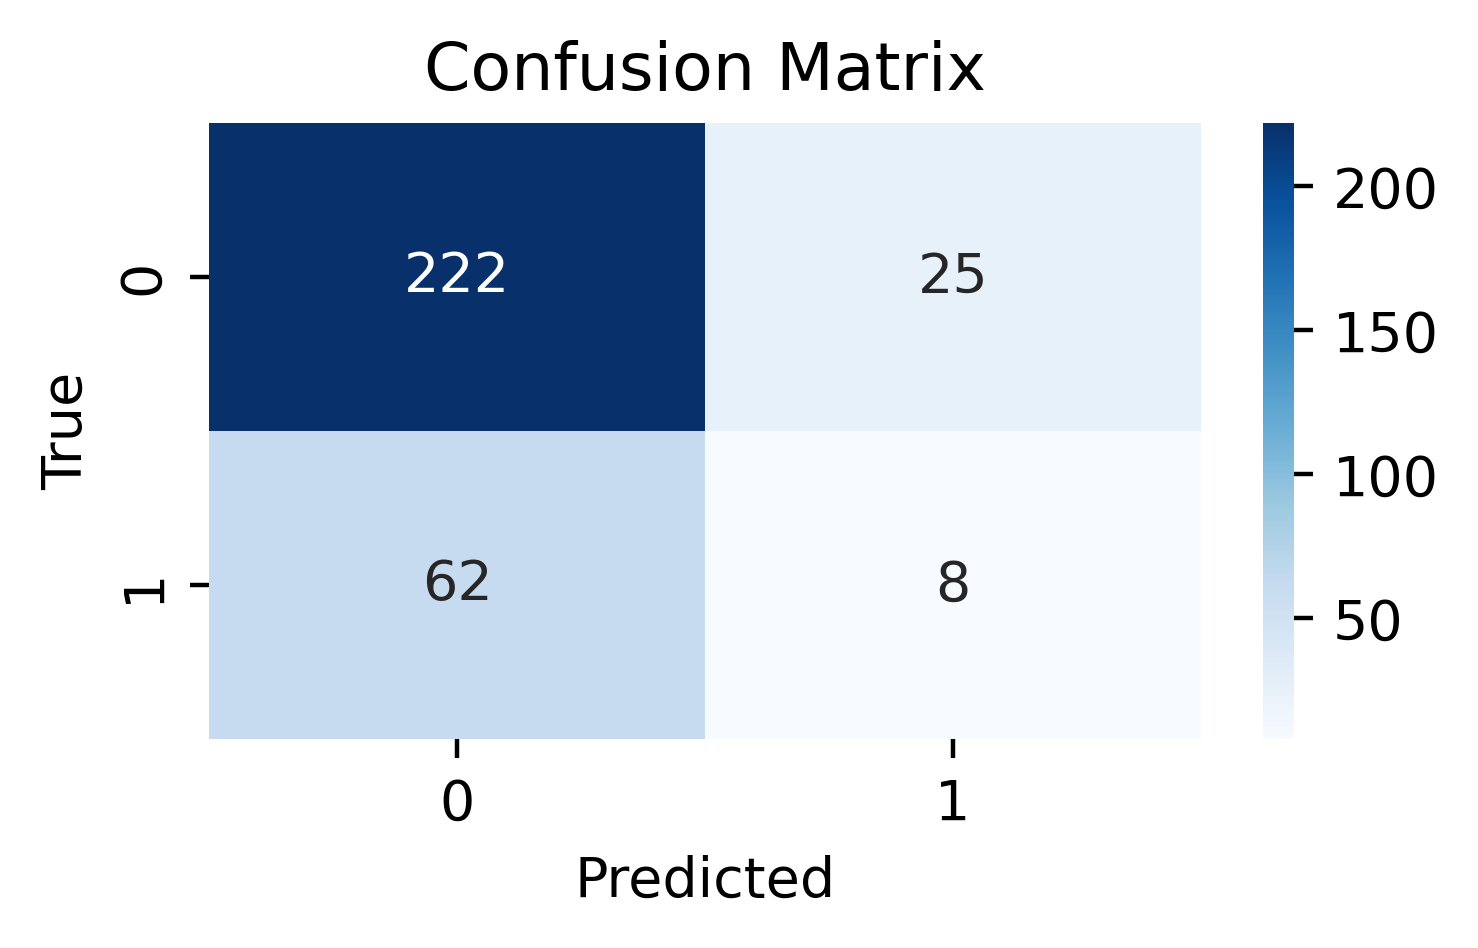

6
              precision    recall  f1-score   support

         0.0       0.78      0.85      0.81       247
         1.0       0.21      0.14      0.17        70

    accuracy                           0.69       317
   macro avg       0.50      0.50      0.49       317
weighted avg       0.65      0.69      0.67       317



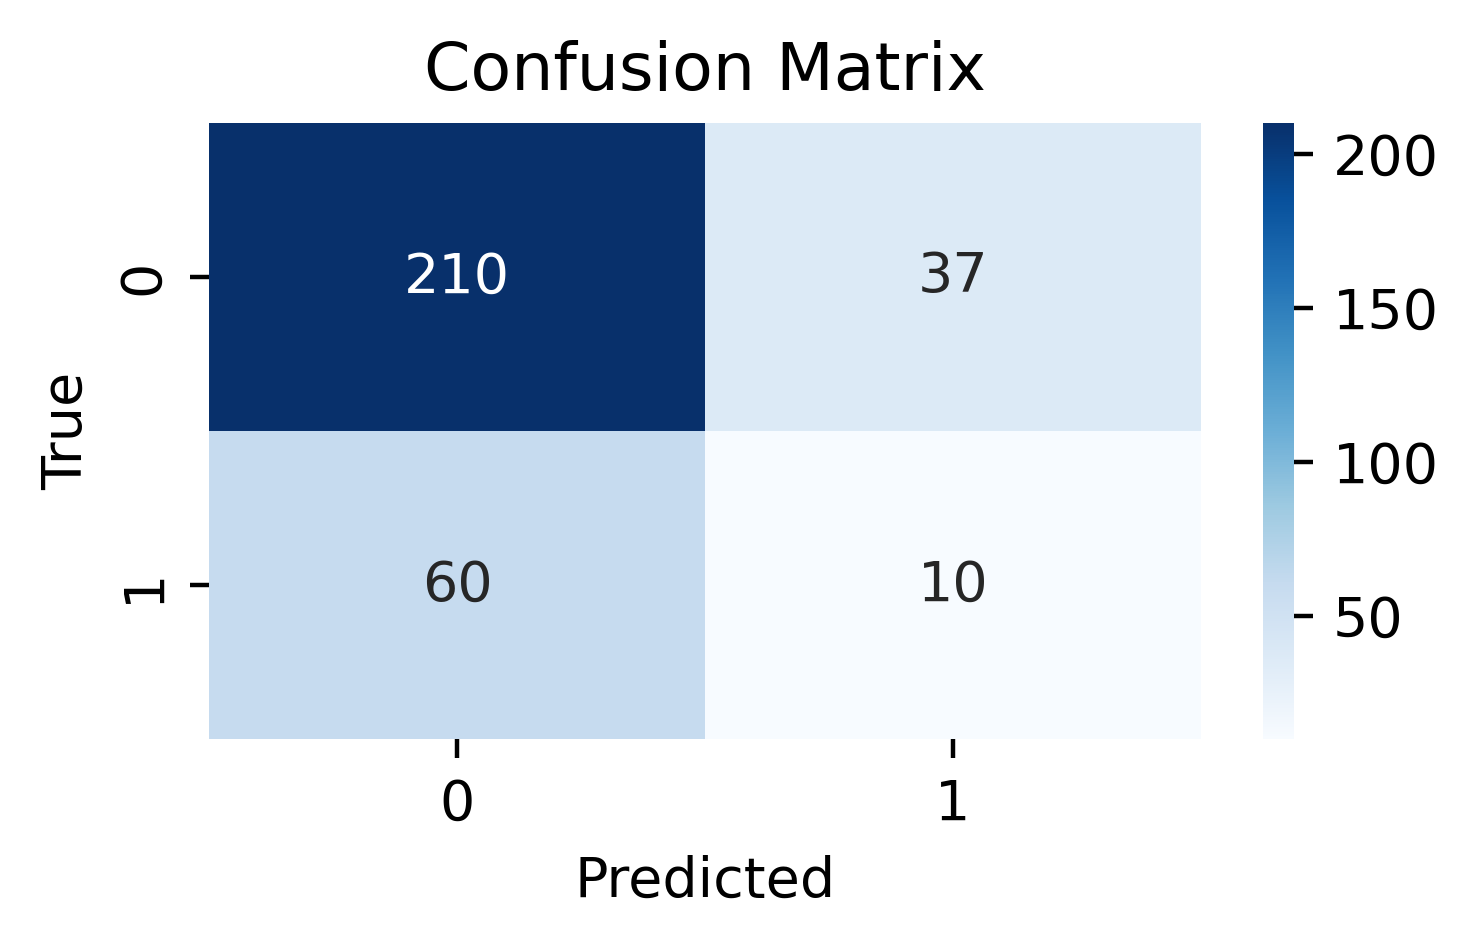

5
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79       247
         1.0       0.21      0.19      0.20        70

    accuracy                           0.67       317
   macro avg       0.49      0.49      0.49       317
weighted avg       0.65      0.67      0.66       317



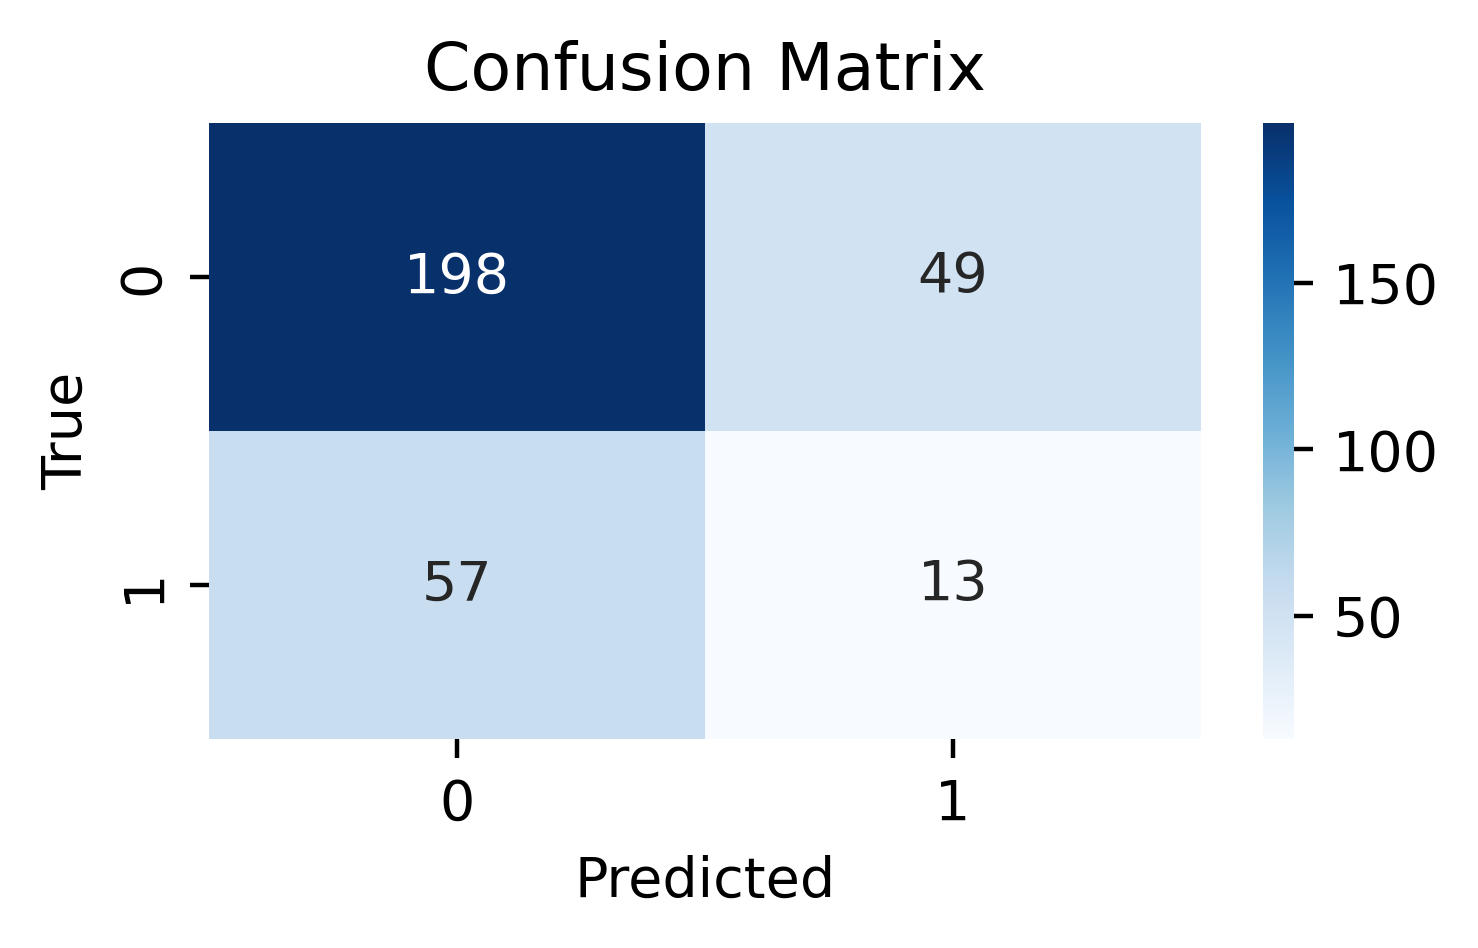

4
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76       247
         1.0       0.20      0.21      0.21        70

    accuracy                           0.63       317
   macro avg       0.48      0.48      0.48       317
weighted avg       0.64      0.63      0.64       317



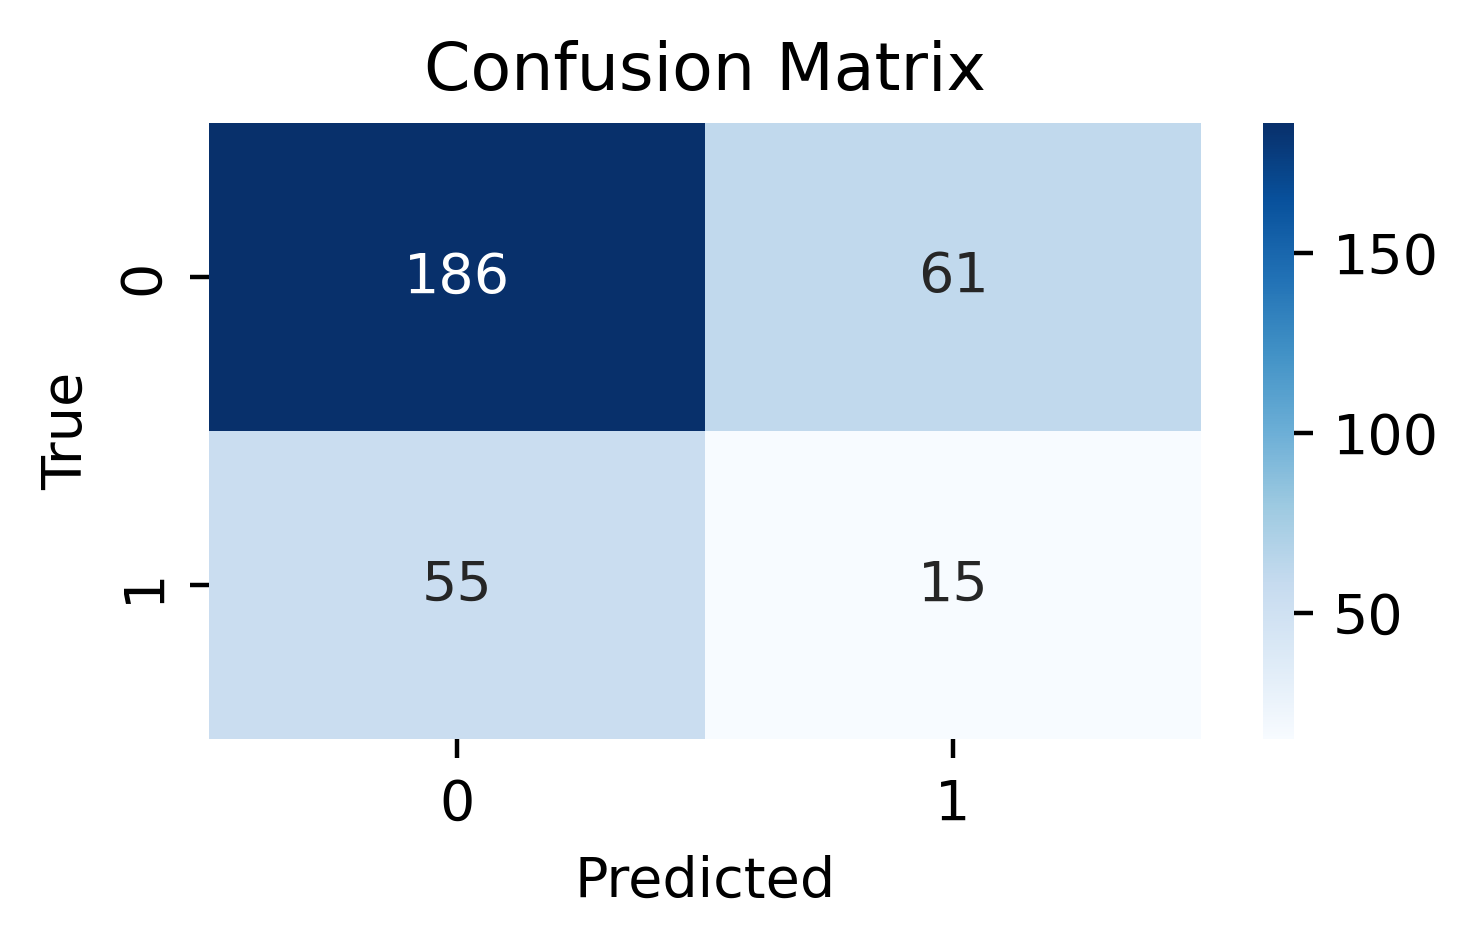

3
              precision    recall  f1-score   support

         0.0       0.77      0.67      0.72       247
         1.0       0.21      0.31      0.25        70

    accuracy                           0.59       317
   macro avg       0.49      0.49      0.49       317
weighted avg       0.65      0.59      0.61       317



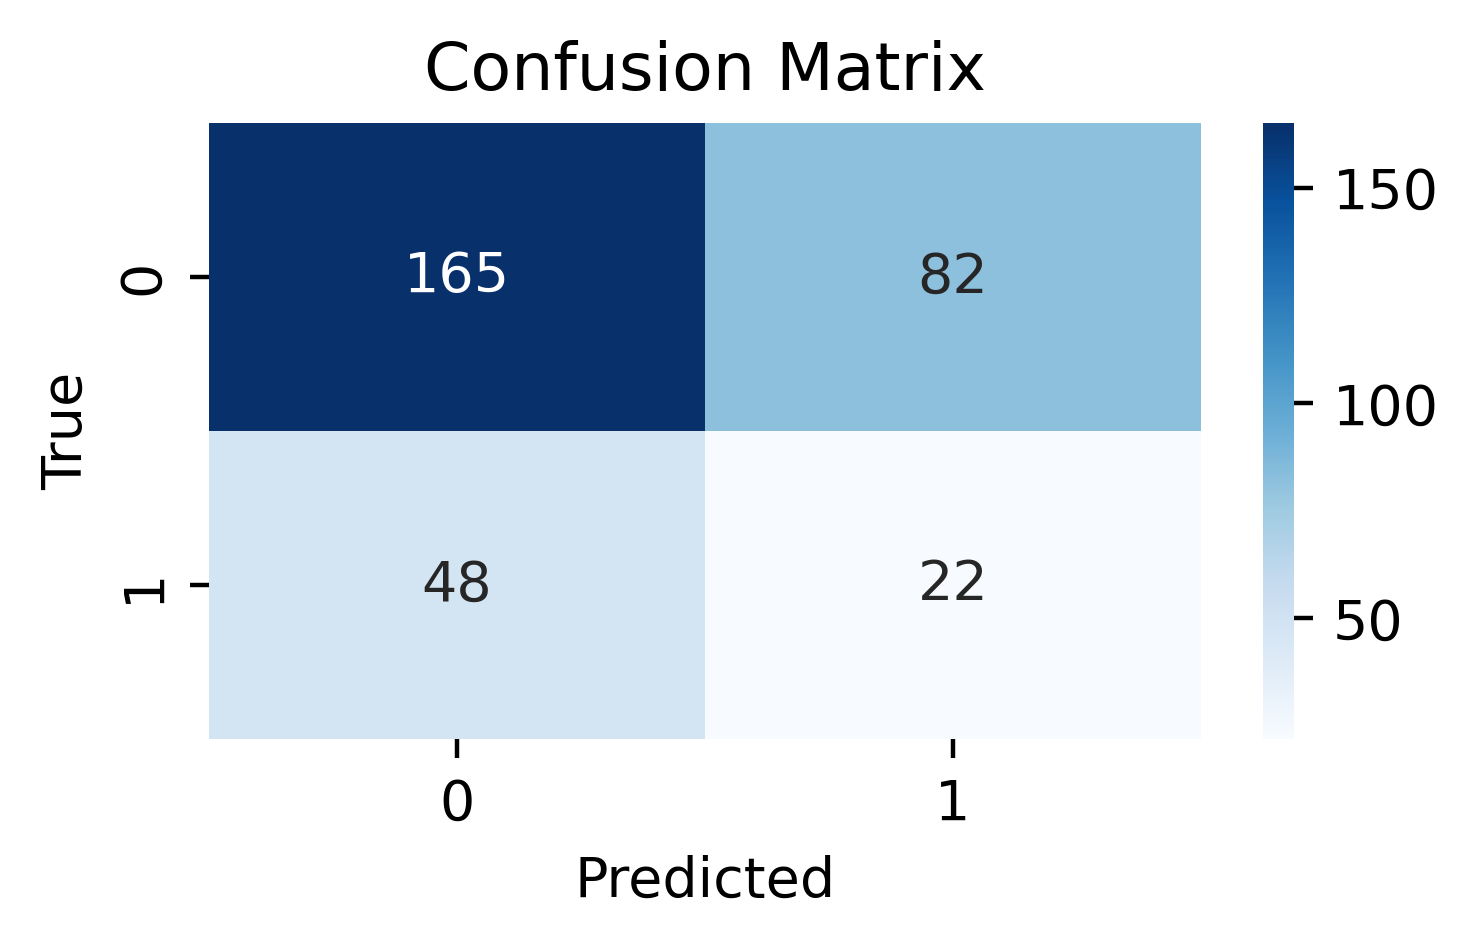

2
              precision    recall  f1-score   support

         0.0       0.78      0.60      0.68       247
         1.0       0.22      0.39      0.28        70

    accuracy                           0.56       317
   macro avg       0.50      0.49      0.48       317
weighted avg       0.65      0.56      0.59       317



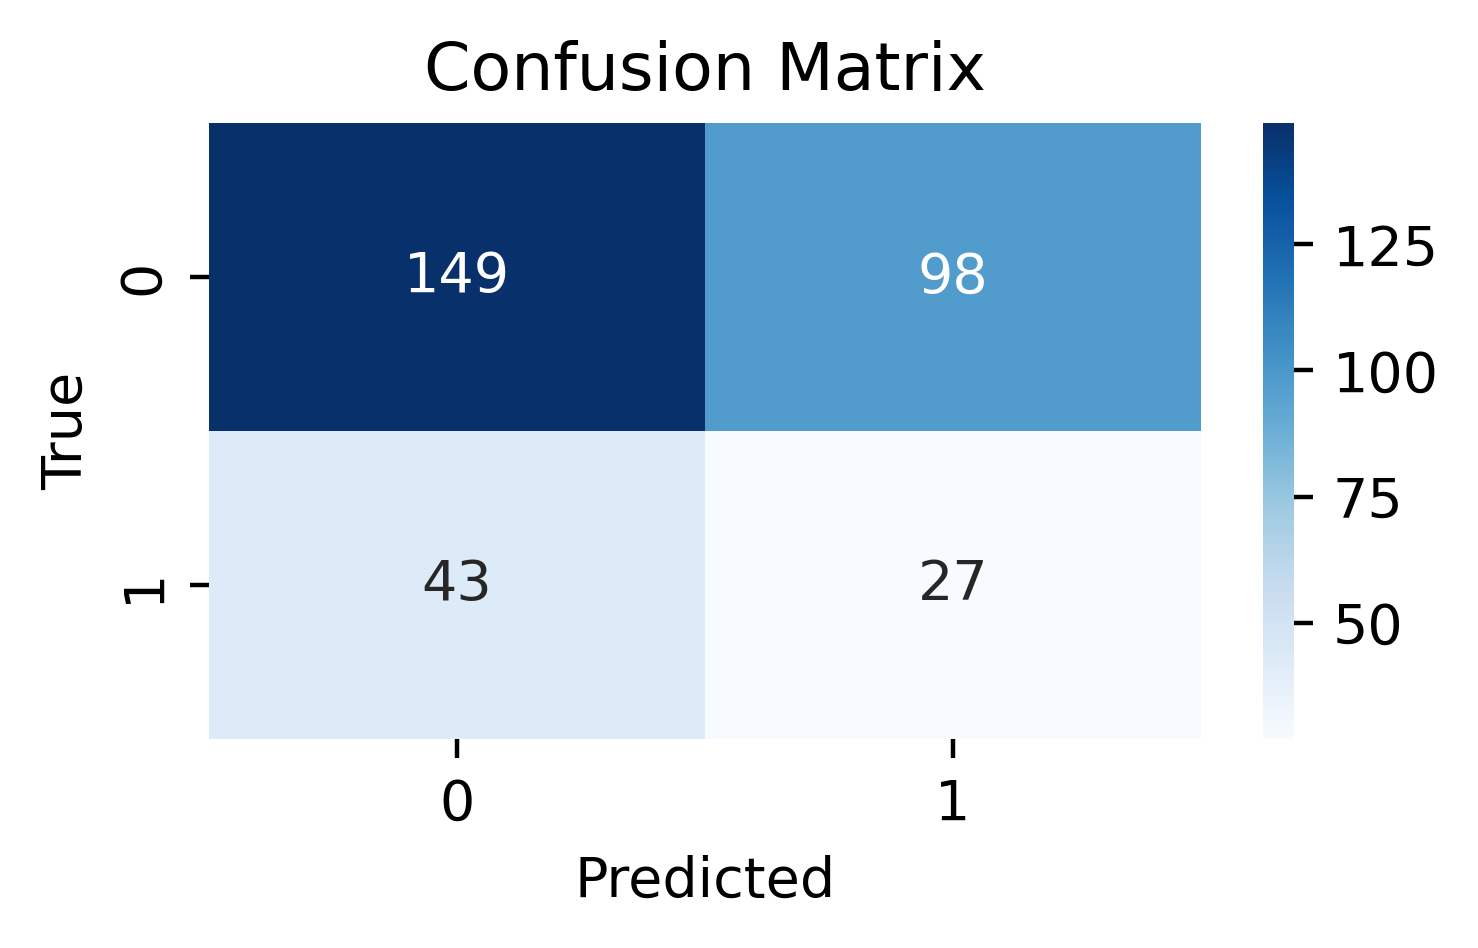

1
              precision    recall  f1-score   support

         0.0       0.77      0.47      0.58       247
         1.0       0.21      0.50      0.30        70

    accuracy                           0.47       317
   macro avg       0.49      0.48      0.44       317
weighted avg       0.64      0.47      0.52       317



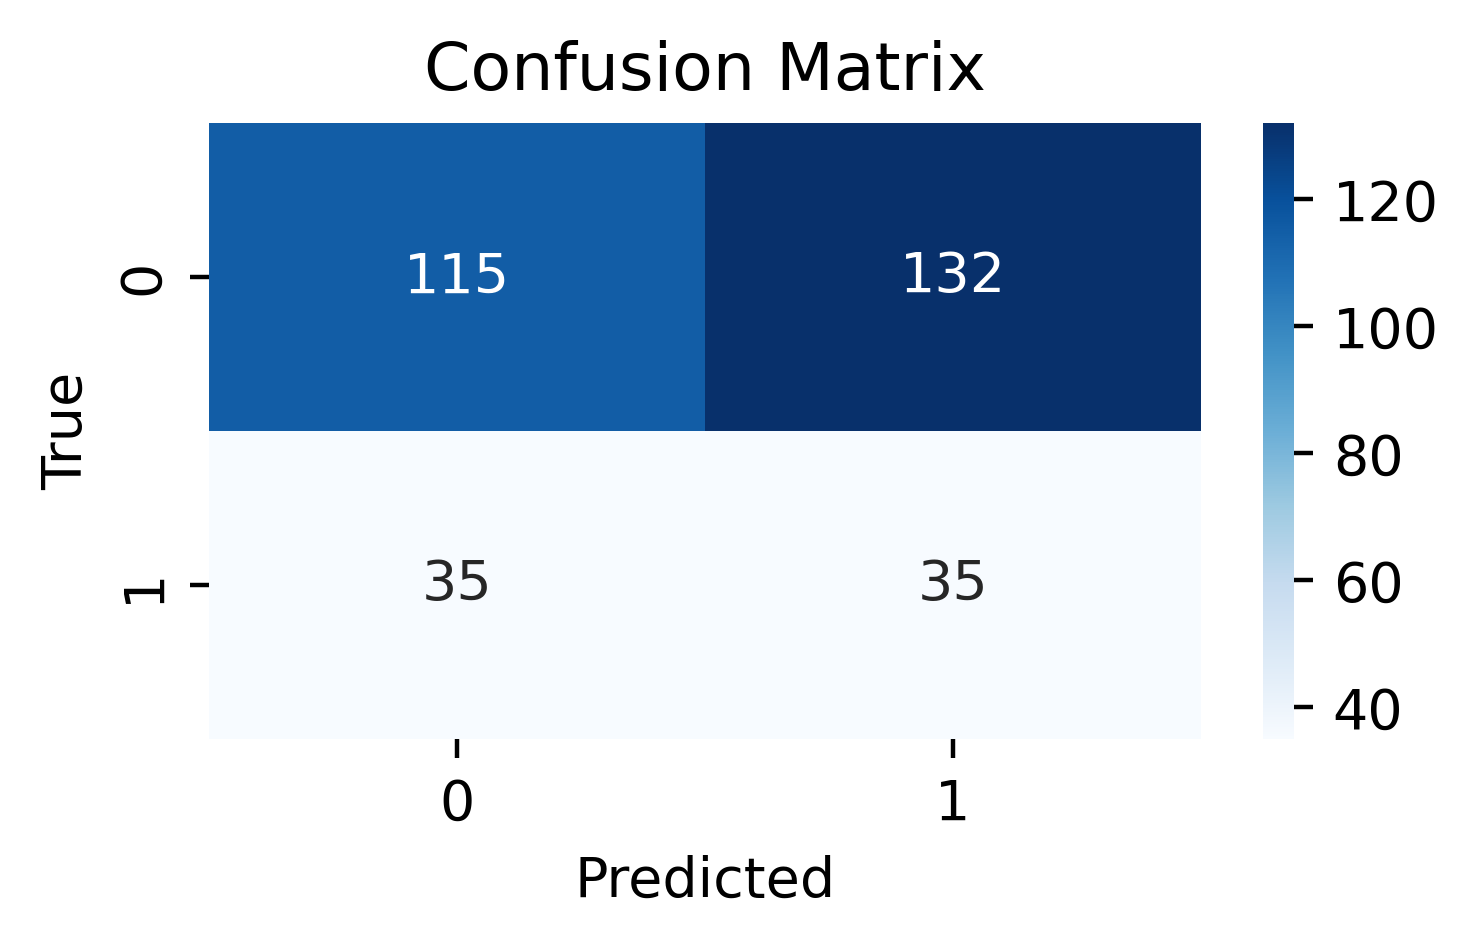

0.75
              precision    recall  f1-score   support

         0.0       0.77      0.45      0.57       247
         1.0       0.22      0.54      0.31        70

    accuracy                           0.47       317
   macro avg       0.50      0.49      0.44       317
weighted avg       0.65      0.47      0.51       317



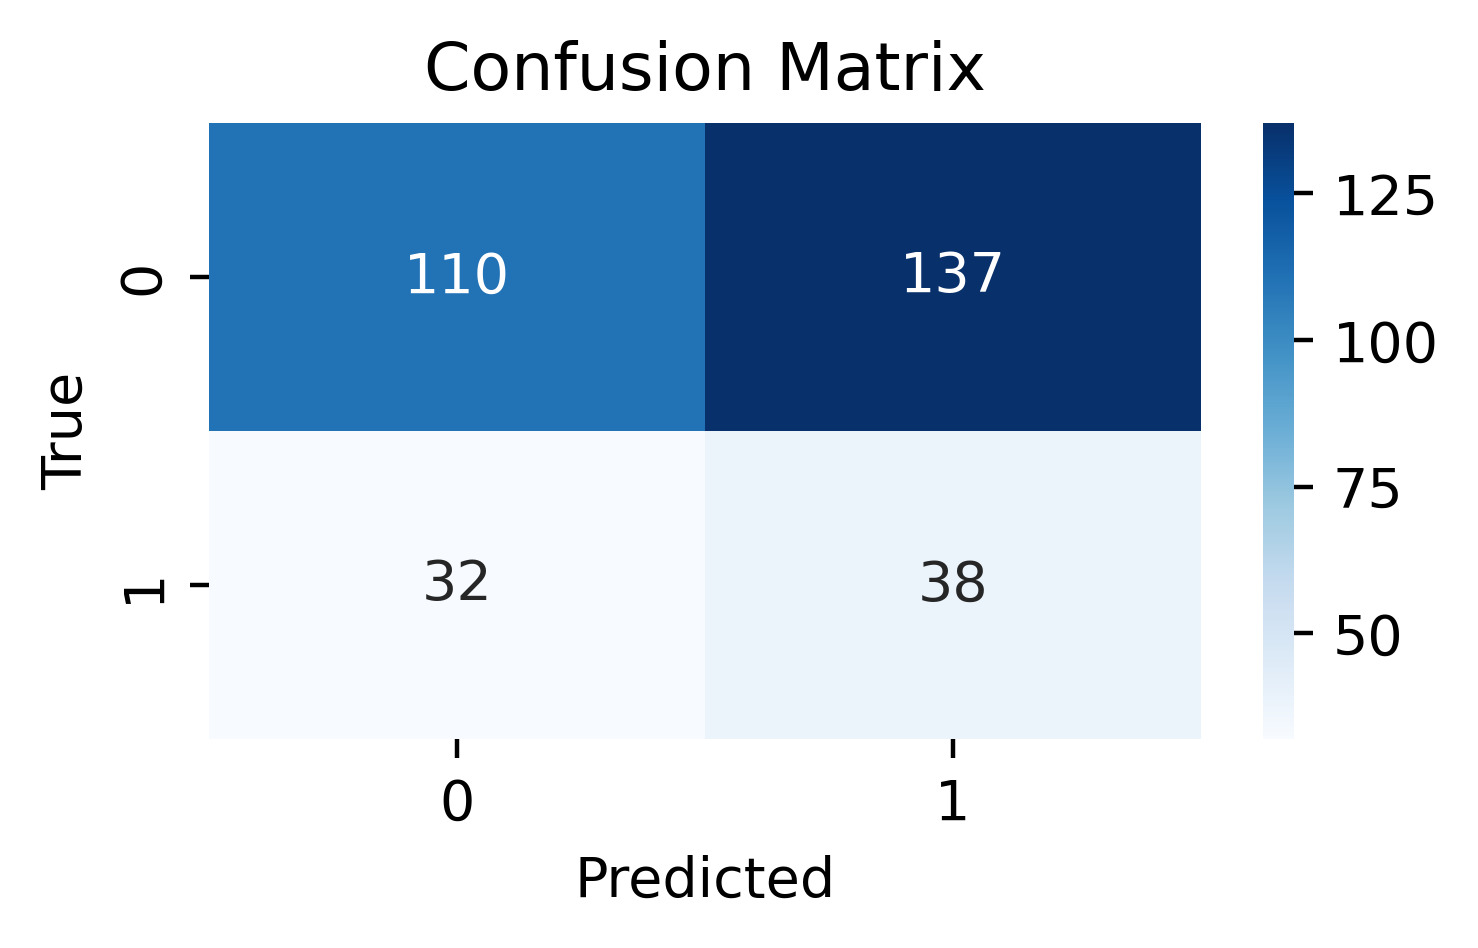

0.5
              precision    recall  f1-score   support

         0.0       0.79      0.43      0.56       247
         1.0       0.23      0.60      0.33        70

    accuracy                           0.47       317
   macro avg       0.51      0.51      0.44       317
weighted avg       0.67      0.47      0.51       317



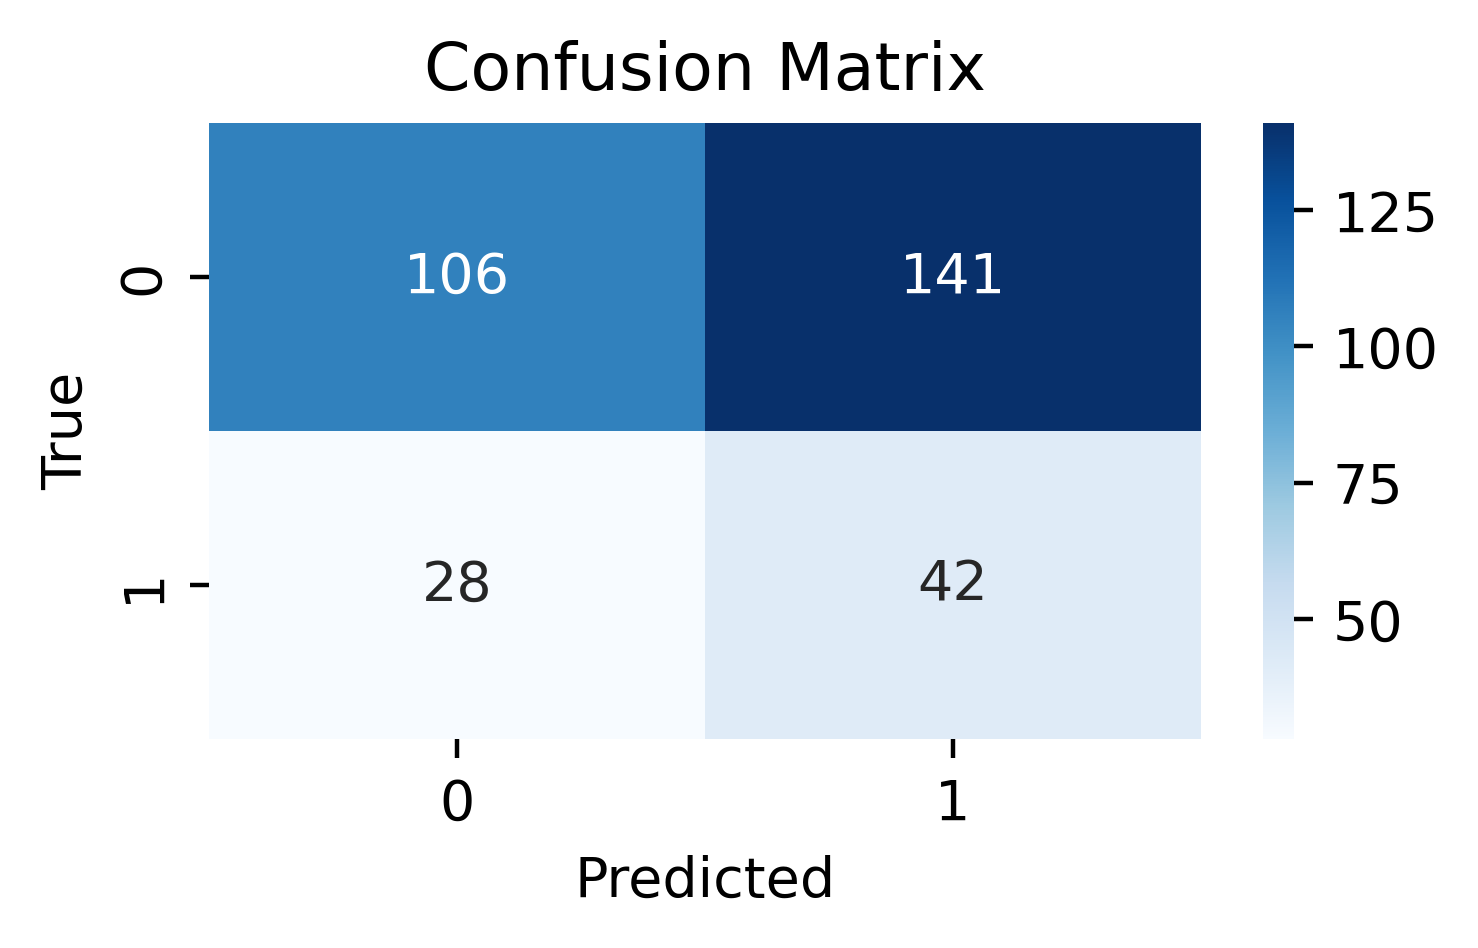

0
              precision    recall  f1-score   support

         0.0       0.80      0.39      0.52       247
         1.0       0.23      0.66      0.34        70

    accuracy                           0.45       317
   macro avg       0.52      0.52      0.43       317
weighted avg       0.67      0.45      0.48       317



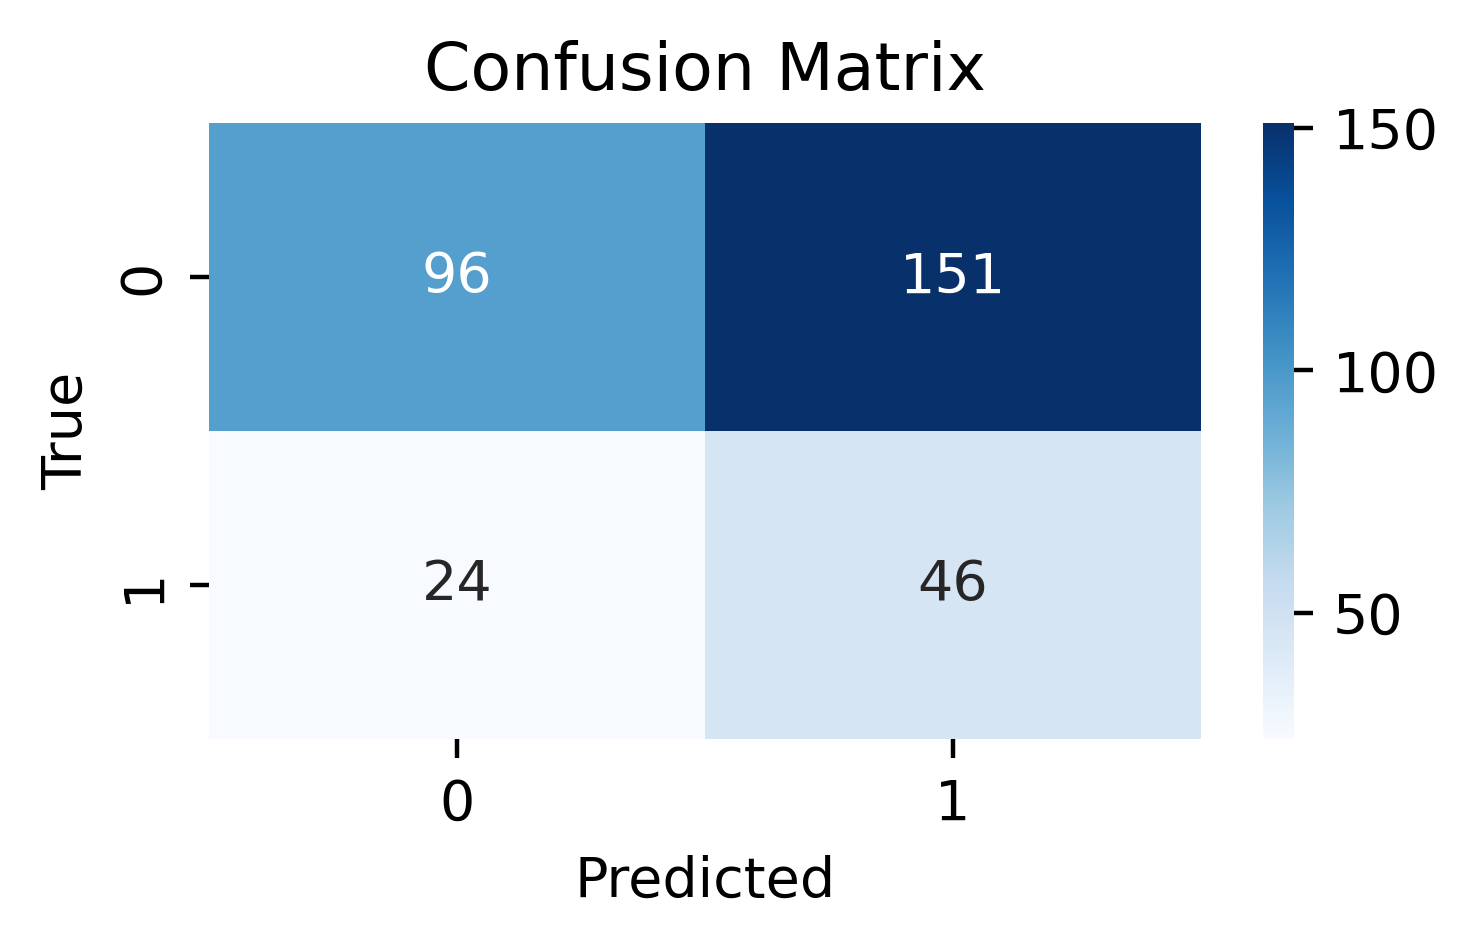

,weighted_avg_f1,macro_avg_f1,true_f1_score,accuracy,MCC,model_run
diff_threshold,,,,,,
7.00,0.685820,0.495749,0.155340,0.725552,0.017754,b1_absolute
6.00,0.670736,0.491660,0.170940,0.694006,-0.008101,b1_absolute
5.00,0.658147,0.492907,0.196970,0.665615,-0.013246,b1_absolute
4.00,0.639339,0.483887,0.205479,0.634069,-0.031749,b1_absolute
3.00,0.614816,0.485132,0.252874,0.589905,-0.015636,b1_absolute
2.00,0.590070,0.477869,0.276923,0.555205,-0.009376,b1_absolute
1.00,0.516635,0.437352,0.295359,0.473186,-0.028590,b1_absolute
0.75,0.509167,0.437878,0.310204,0.466877,-0.009842,b1_absolute
0.50,0.506875,0.444223,0.332016,0.466877,0.024477,b1_absolute


In [15]:
# the difference of the observed to the matched alpha diversity value is
# expected to be larger after abx exposure
diff_metric = f"diff_2_matched_{metric}"

df_results_b1_absolute = pd.DataFrame()
df_results_b1_absolute.index.name = "diff_threshold"

for thresh in reversed([0, 0.5, 0.75, 1, 2, 3, 4, 5, 6, 7]):
    print(thresh)
    unsupervised_subset_th_b1 = unsupervised_subset.copy()

    # define predicted target:
    unsupervised_subset_th_b1["pred_target"] = (
        unsupervised_subset_th_b1[diff_metric] > thresh
    )

    # evaluate classification
    df_results_b1_absolute = report_metrics(
        unsupervised_subset_th_b1["true_target"],
        unsupervised_subset_th_b1["pred_target"],
        df_results_b1_absolute,
        thresh,
    )
df_results_b1_absolute["model_run"] = "b1_absolute"
df_results_b1_absolute

### B2: Set relative threshold for change in difference to matched diversity

Relative increase: 1.05
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       247
         1.0       0.14      0.14      0.14        70

    accuracy                           0.62       317
   macro avg       0.45      0.45      0.45       317
weighted avg       0.62      0.62      0.62       317



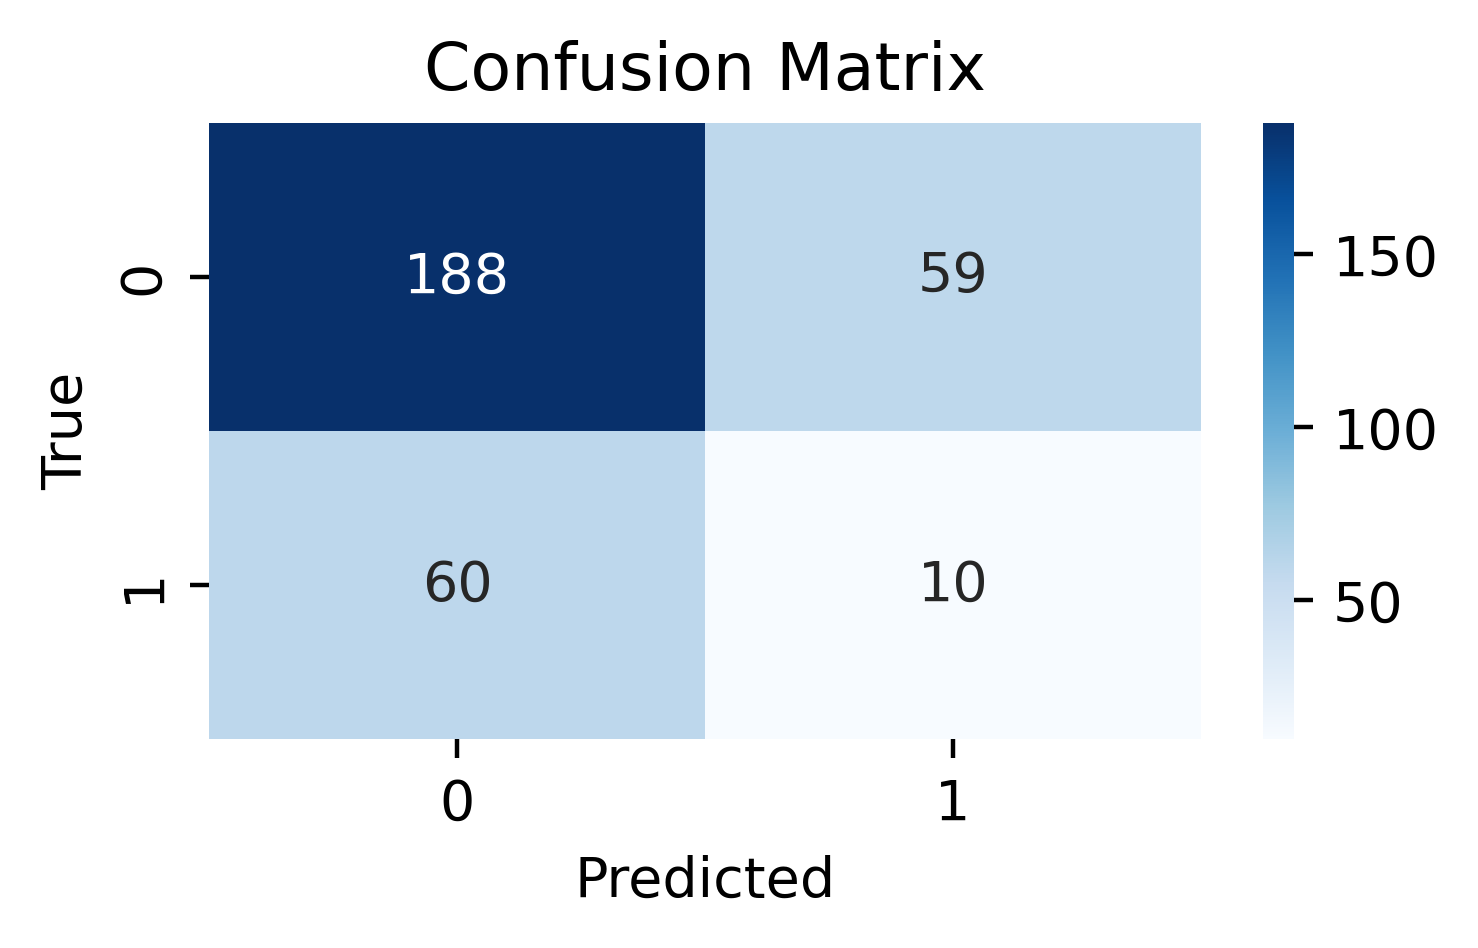

Relative increase: 1.1
              precision    recall  f1-score   support

         0.0       0.76      0.77      0.77       247
         1.0       0.15      0.14      0.15        70

    accuracy                           0.63       317
   macro avg       0.46      0.46      0.46       317
weighted avg       0.63      0.63      0.63       317



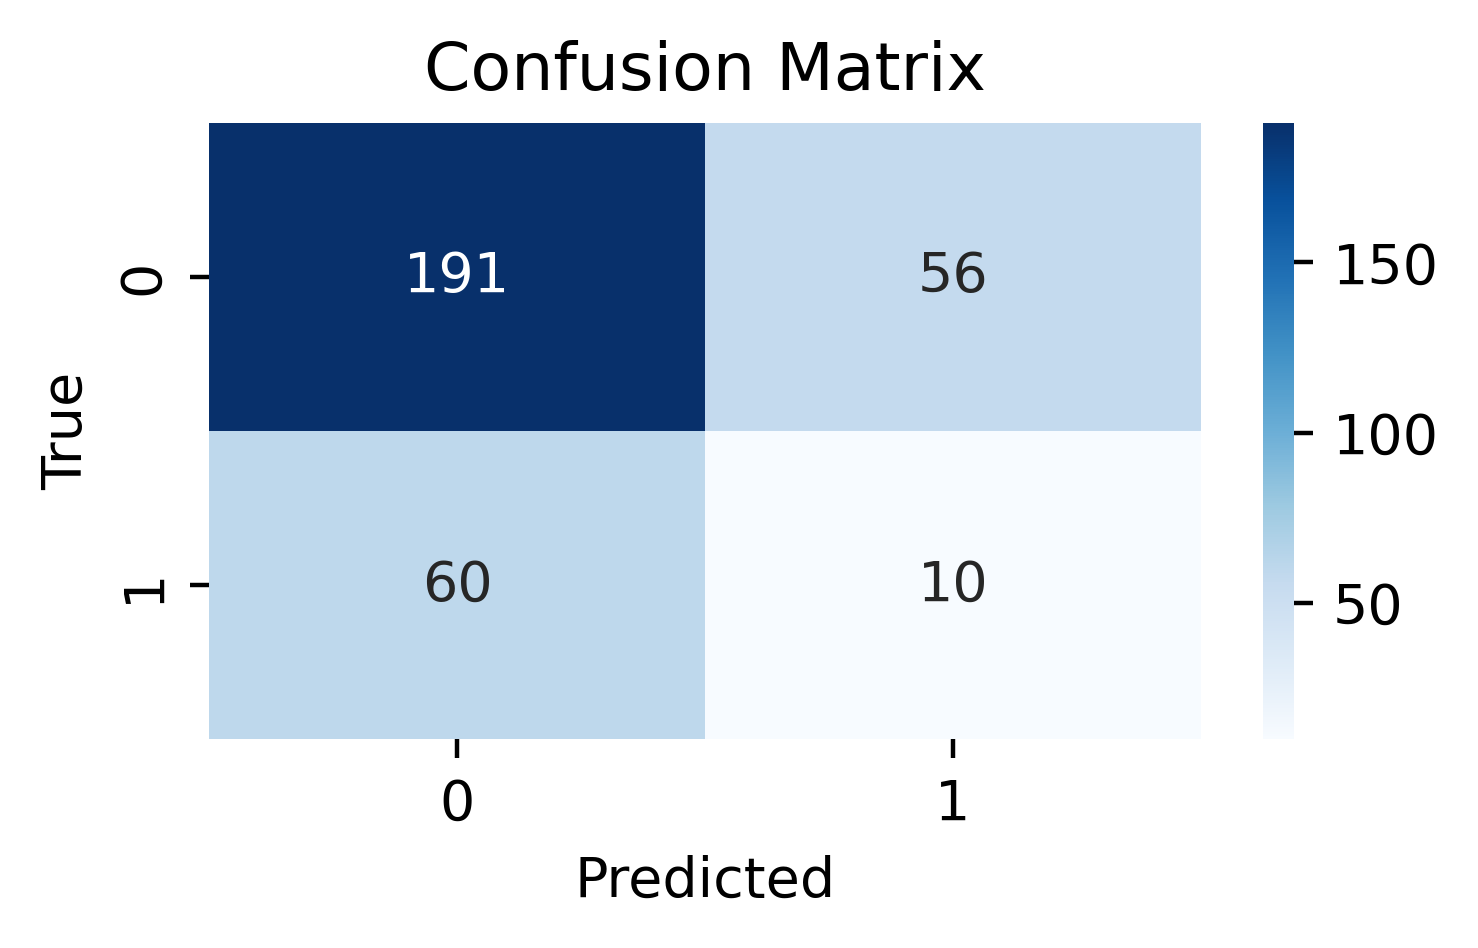

Relative increase: 1.2
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78       247
         1.0       0.17      0.14      0.15        70

    accuracy                           0.65       317
   macro avg       0.47      0.47      0.47       317
weighted avg       0.63      0.65      0.64       317



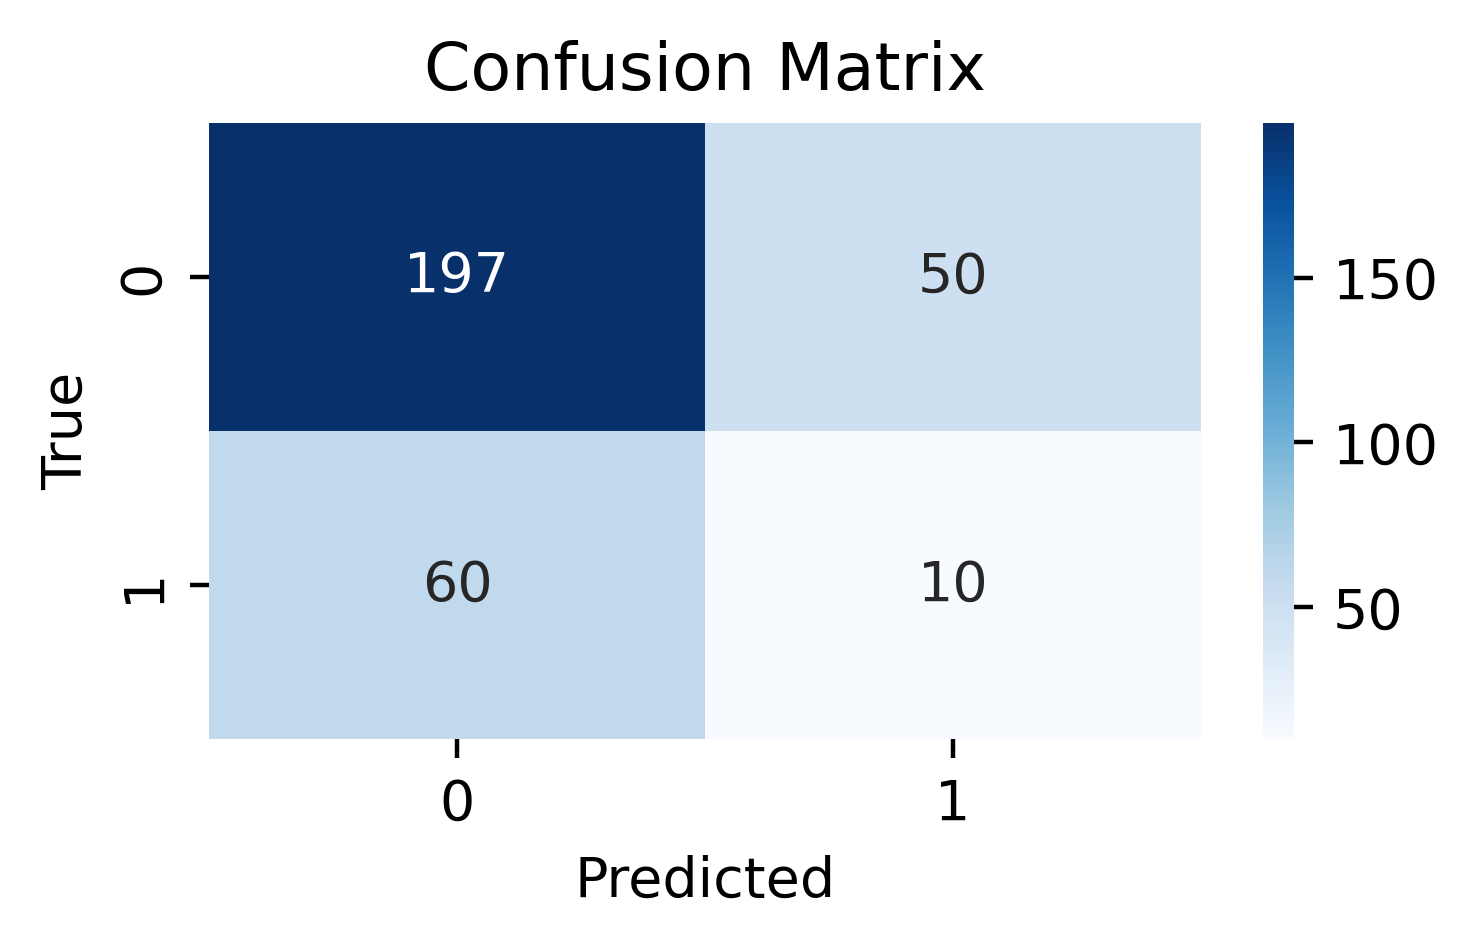

Relative increase: 1.3
              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79       247
         1.0       0.16      0.13      0.14        70

    accuracy                           0.66       317
   macro avg       0.47      0.47      0.47       317
weighted avg       0.63      0.66      0.65       317



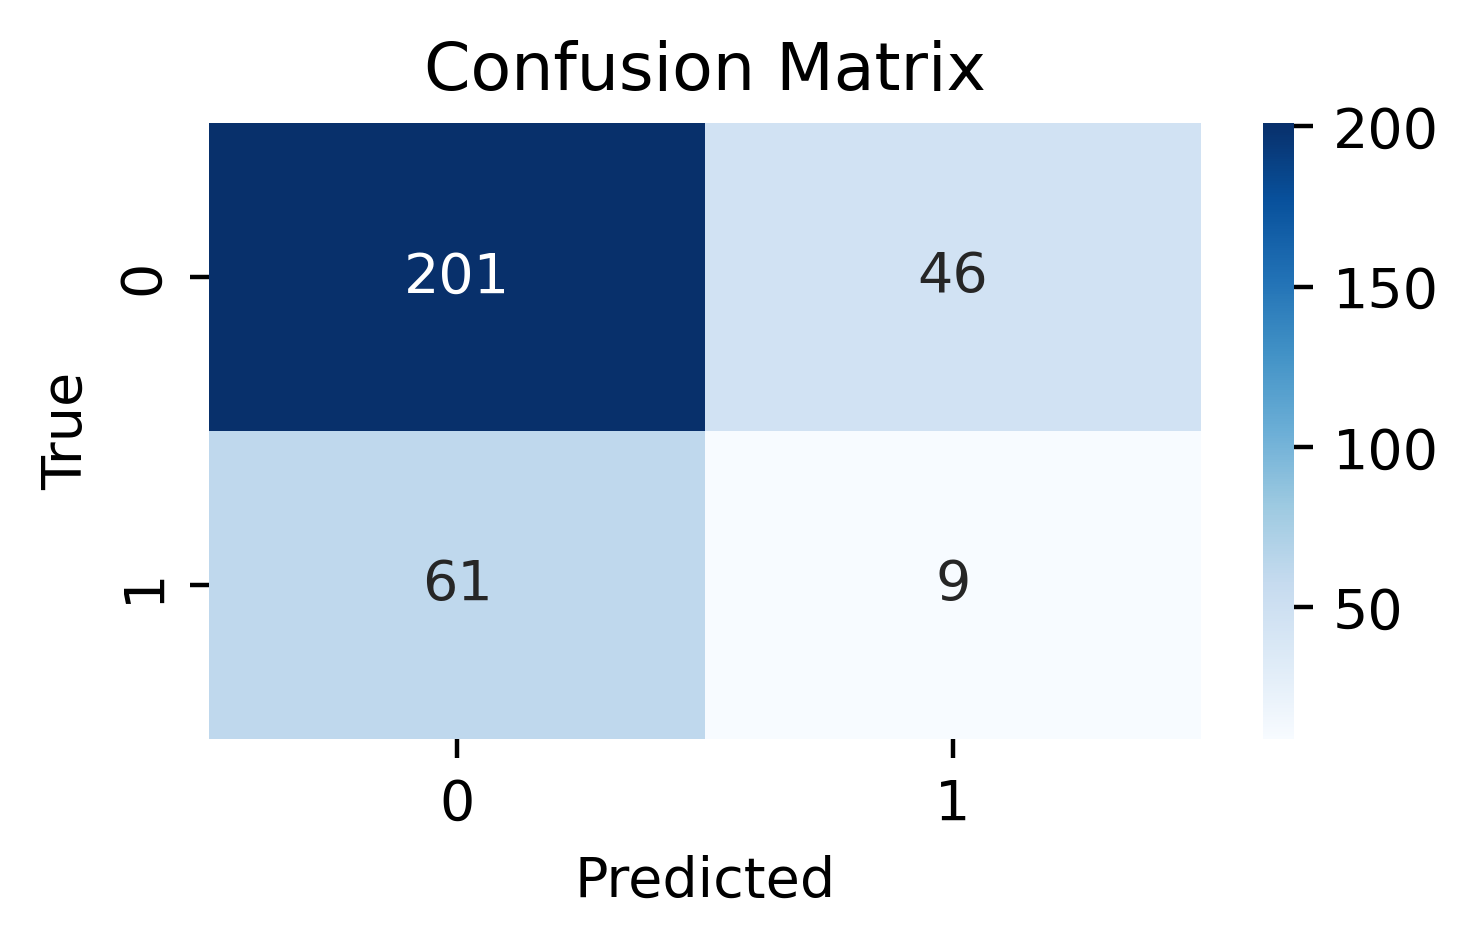

Relative increase: 1.4
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80       247
         1.0       0.17      0.13      0.15        70

    accuracy                           0.67       317
   macro avg       0.47      0.48      0.47       317
weighted avg       0.64      0.67      0.65       317



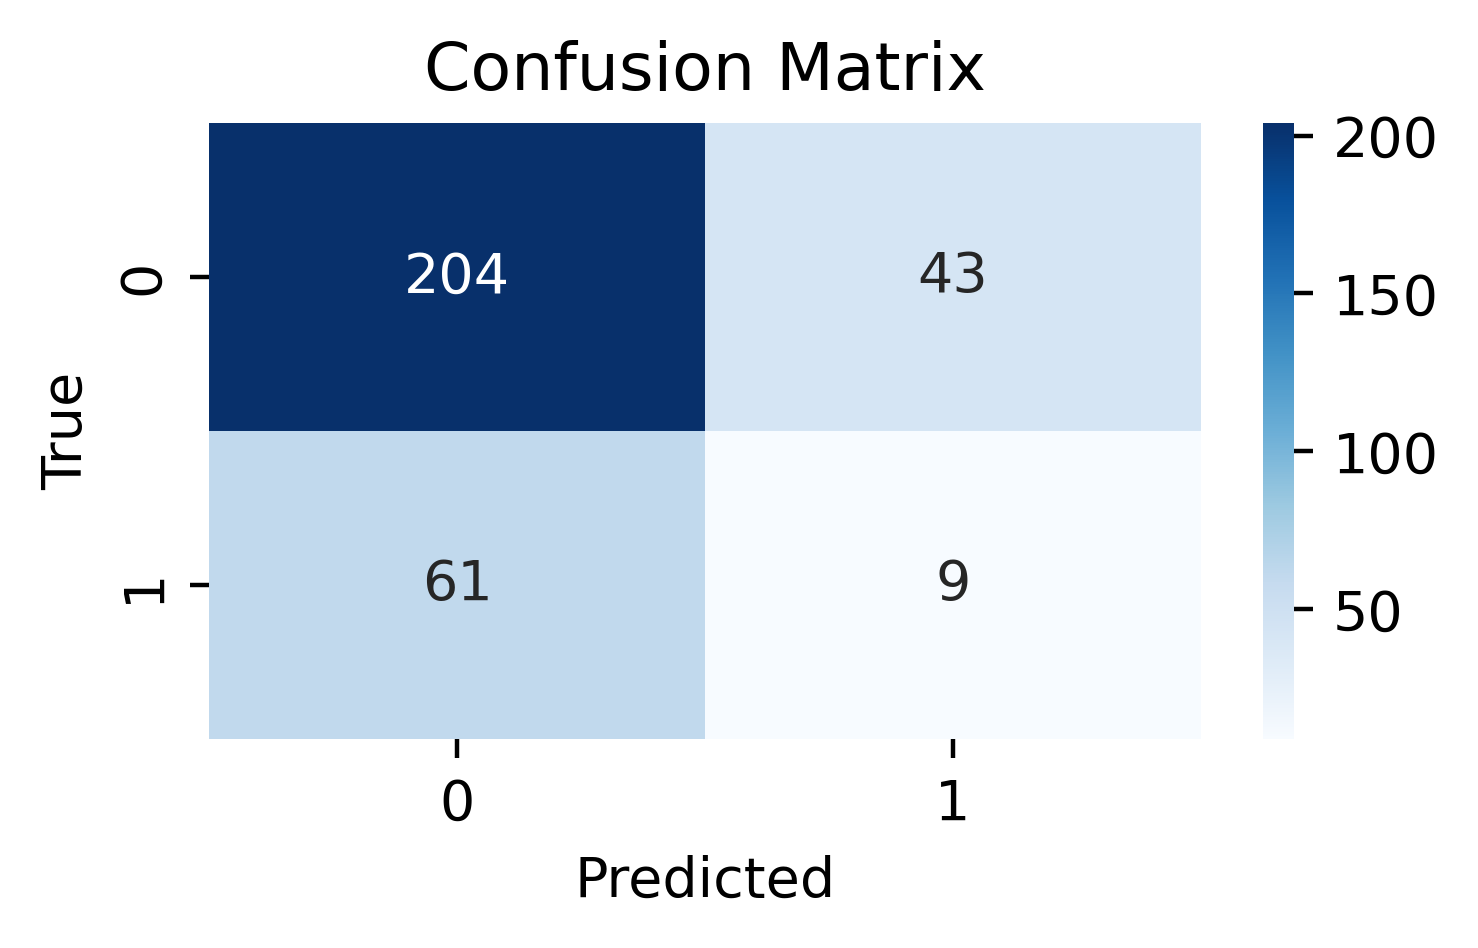

Relative increase: 1.5
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80       247
         1.0       0.16      0.11      0.13        70

    accuracy                           0.68       317
   macro avg       0.47      0.47      0.47       317
weighted avg       0.63      0.68      0.65       317



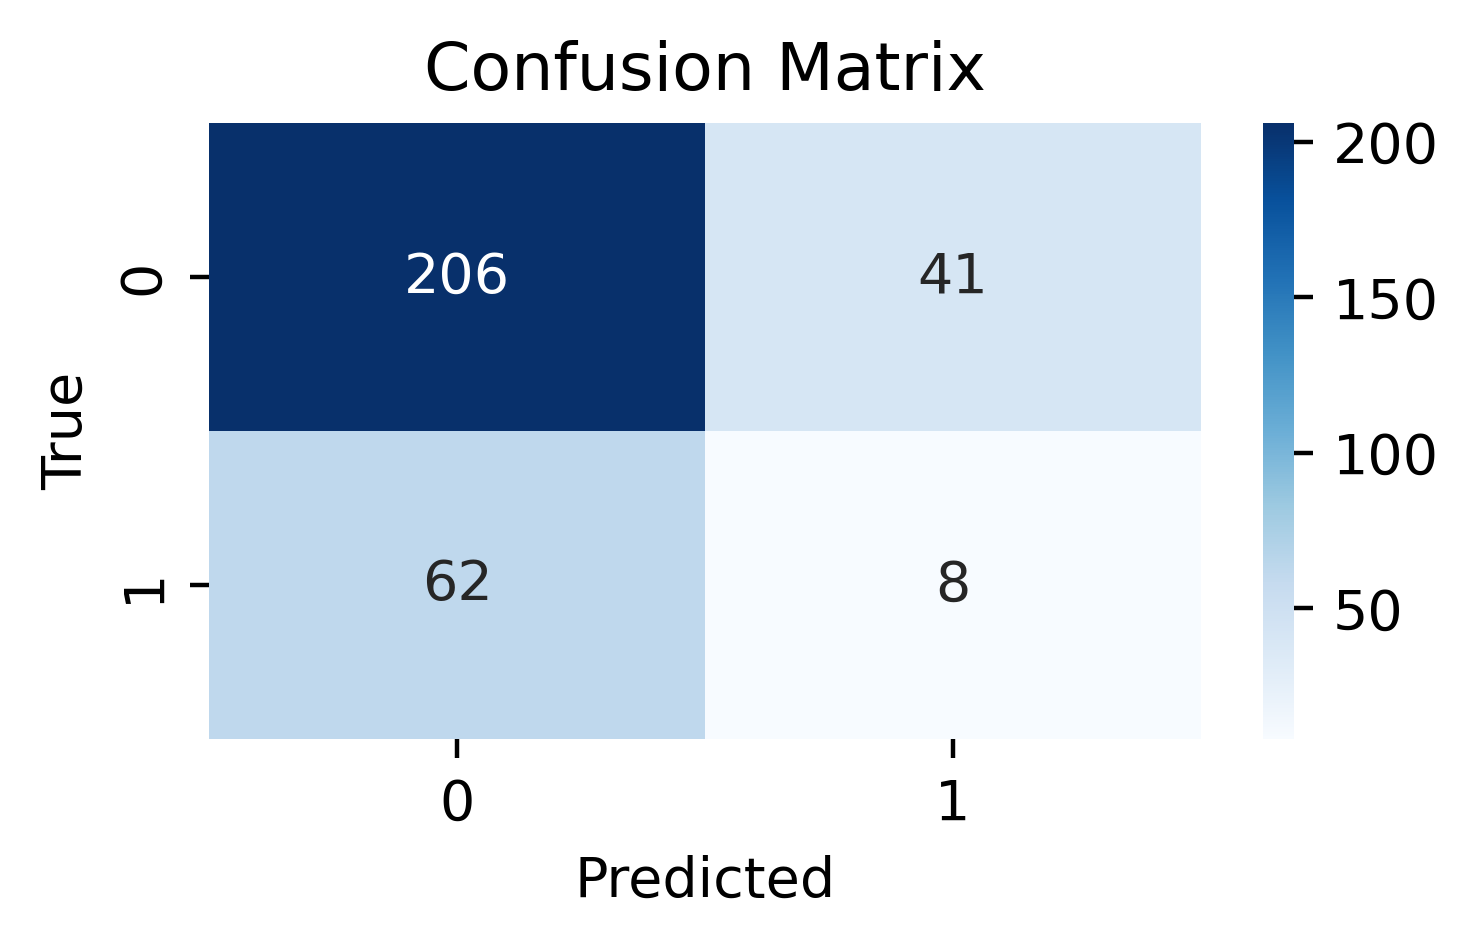

Relative increase: 1.75
              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81       247
         1.0       0.16      0.10      0.12        70

    accuracy                           0.68       317
   macro avg       0.46      0.47      0.46       317
weighted avg       0.63      0.68      0.65       317



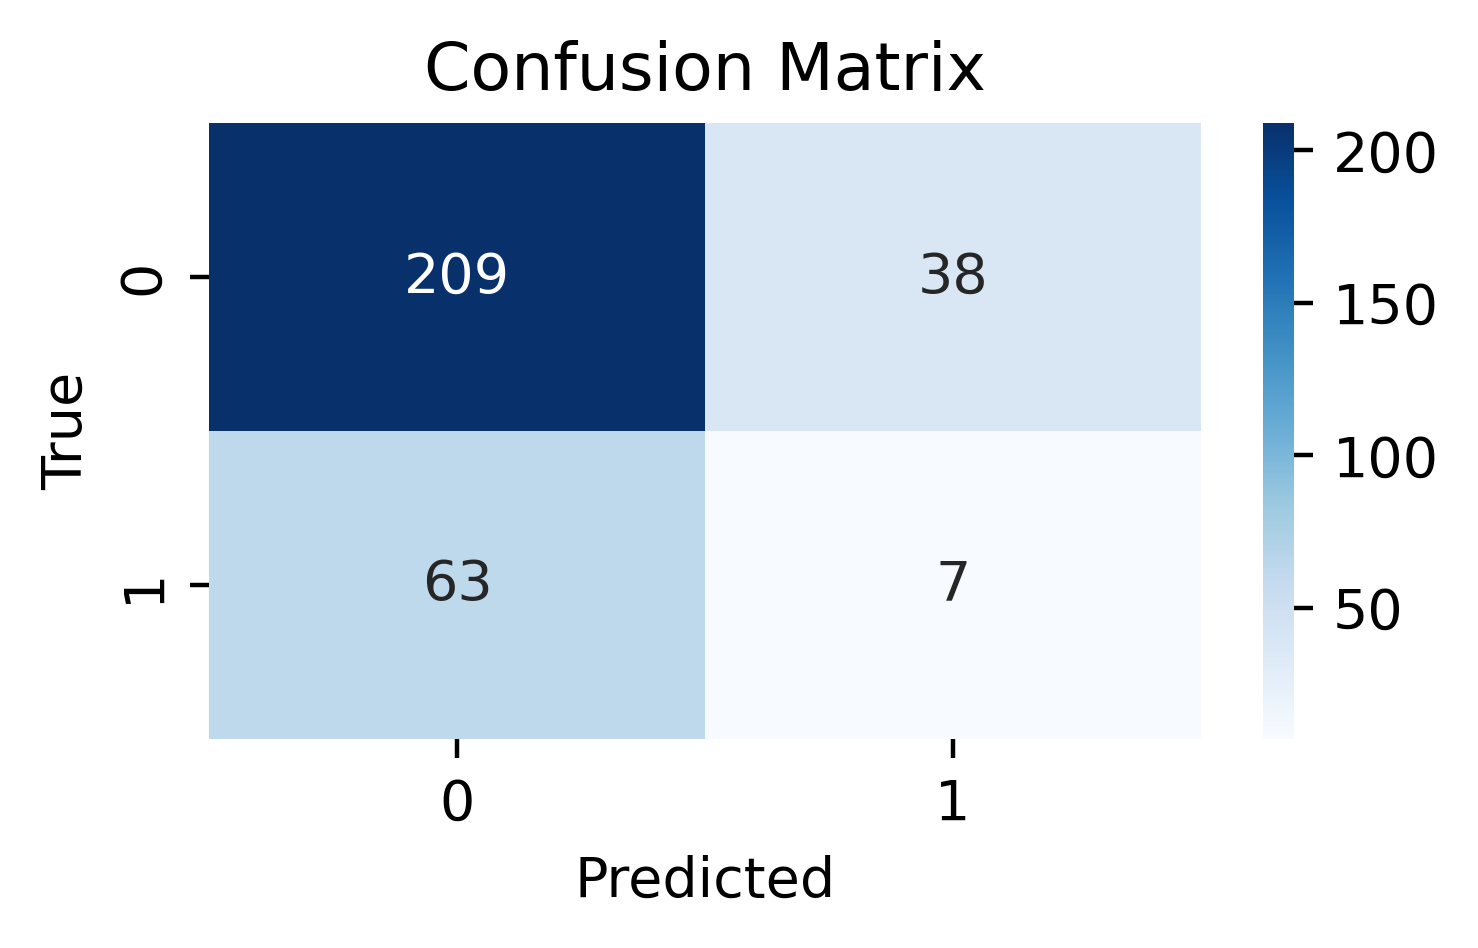

Relative increase: 2.0
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81       247
         1.0       0.15      0.09      0.11        70

    accuracy                           0.69       317
   macro avg       0.46      0.47      0.46       317
weighted avg       0.63      0.69      0.66       317



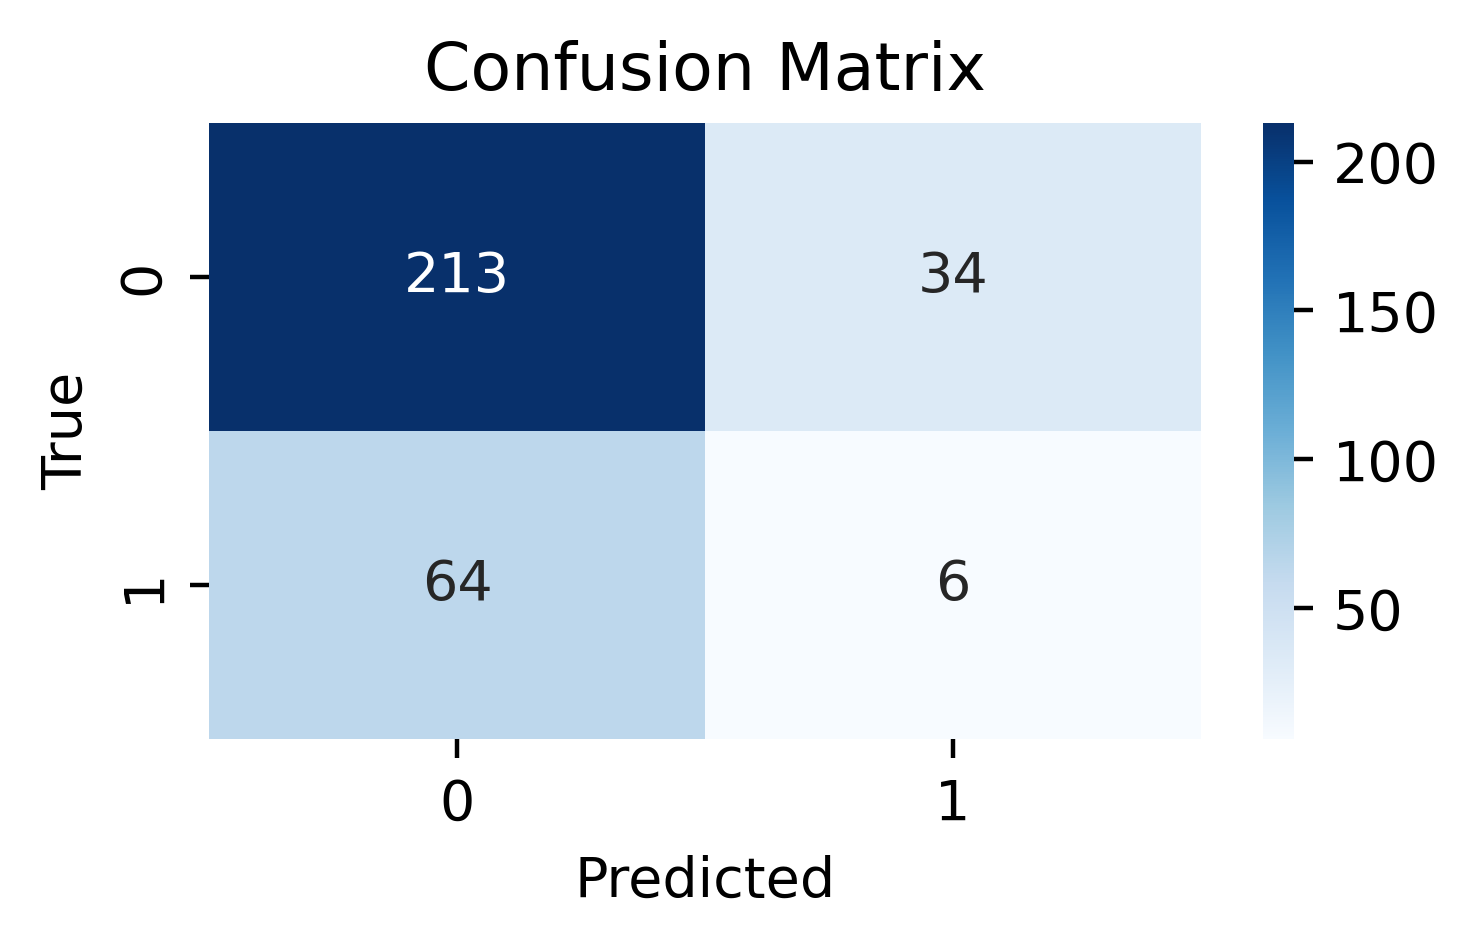

Relative increase: 3
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84       247
         1.0       0.19      0.07      0.10        70

    accuracy                           0.73       317
   macro avg       0.48      0.49      0.47       317
weighted avg       0.65      0.73      0.68       317



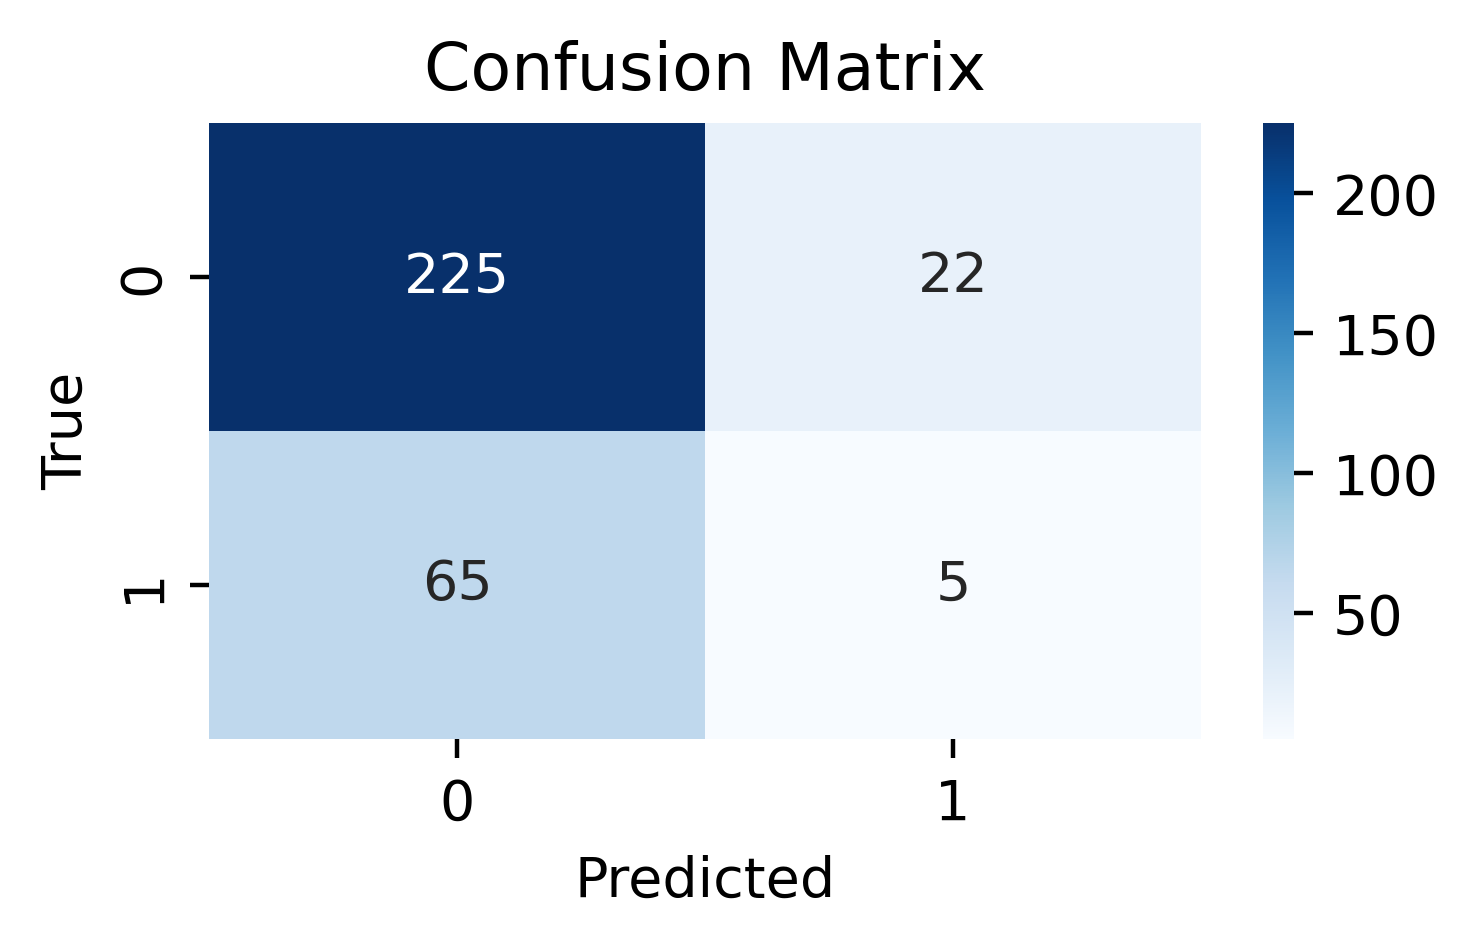

Relative increase: 4
              precision    recall  f1-score   support

         0.0       0.78      0.94      0.85       247
         1.0       0.17      0.04      0.07        70

    accuracy                           0.74       317
   macro avg       0.47      0.49      0.46       317
weighted avg       0.64      0.74      0.68       317



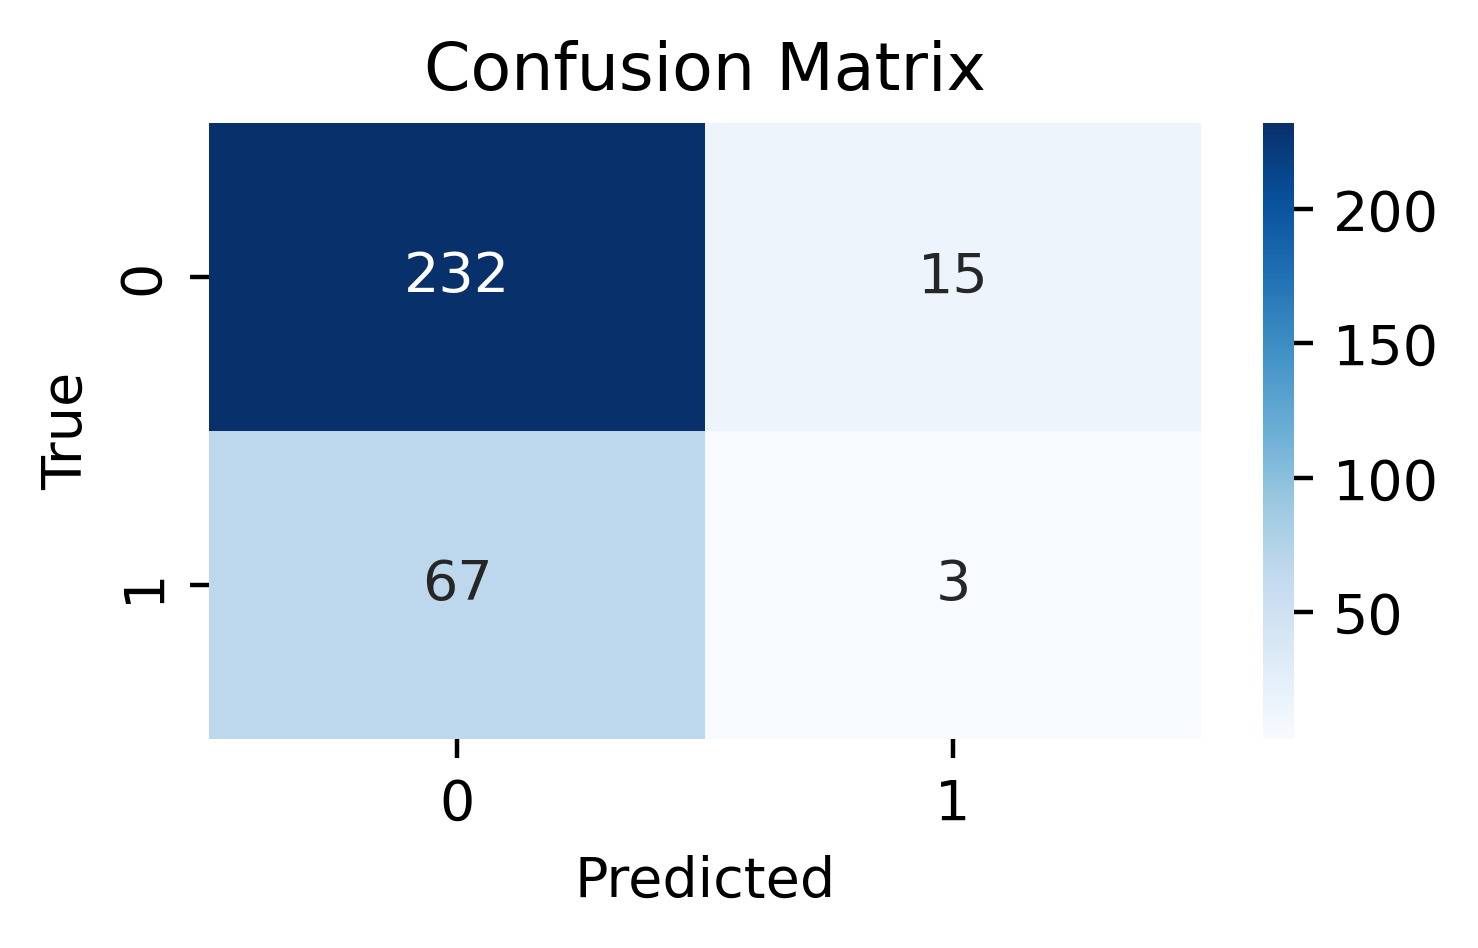

,weighted_avg_f1,macro_avg_f1,true_f1_score,accuracy,MCC,model_run
rel_increase,,,,,,
1.05,0.623635,0.451740,0.143885,0.624606,-0.096507,b2_relative
1.10,0.630158,0.457064,0.147059,0.634069,-0.085676,b2_relative
1.20,0.643093,0.467796,0.153846,0.652997,-0.063081,b2_relative
1.30,0.647182,0.466892,0.144000,0.662461,-0.063163,b2_relative
1.40,0.653489,0.472208,0.147541,0.671924,-0.050986,b2_relative
1.50,0.653034,0.467227,0.134454,0.675079,-0.059330,b2_relative
1.75,0.654430,0.463567,0.121739,0.681388,-0.063997,b2_relative
2.00,0.657545,0.461034,0.109091,0.690852,-0.064880,b2_relative
3.00,0.675709,0.470541,0.103093,0.725552,-0.026213,b2_relative


In [16]:
df_results_b2_relative = pd.DataFrame()
df_results_b2_relative.index.name = "rel_increase"

for rel_inc in reversed([4, 3, 2.0, 1.75, 1.5, 1.4, 1.3, 1.2, 1.1, 1.05]):
    unsupervised_subset_b2_rel = unsupervised_subset.copy()

    # define predicted target: rel_inc-ing of matched diversity difference
    # within 3 months
    print(f"Relative increase: {rel_inc}")

    unsupervised_subset_b2_rel["pred_target"] = 0

    pred_true = (
        unsupervised_subset_b2_rel["diff_2_matched_div_alpha_faith_pd_rel_change"]
        >= rel_inc
    ) & (unsupervised_subset_b2_rel["month5_bin_diff"] <= 3.0)
    unsupervised_subset_b2_rel.loc[pred_true, "pred_target"] = 1

    # evaluate classification
    df_results_b2_relative = report_metrics(
        unsupervised_subset_b2_rel["true_target"],
        unsupervised_subset_b2_rel["pred_target"],
        df_results_b2_relative,
        rel_inc,
    )
df_results_b2_relative["model_run"] = "b2_relative"
df_results_b2_relative

### B3: RF-based classifier: fully static

              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        89
         1.0       0.22      0.09      0.13        22

    accuracy                           0.76       111
   macro avg       0.51      0.51      0.49       111
weighted avg       0.69      0.76      0.71       111



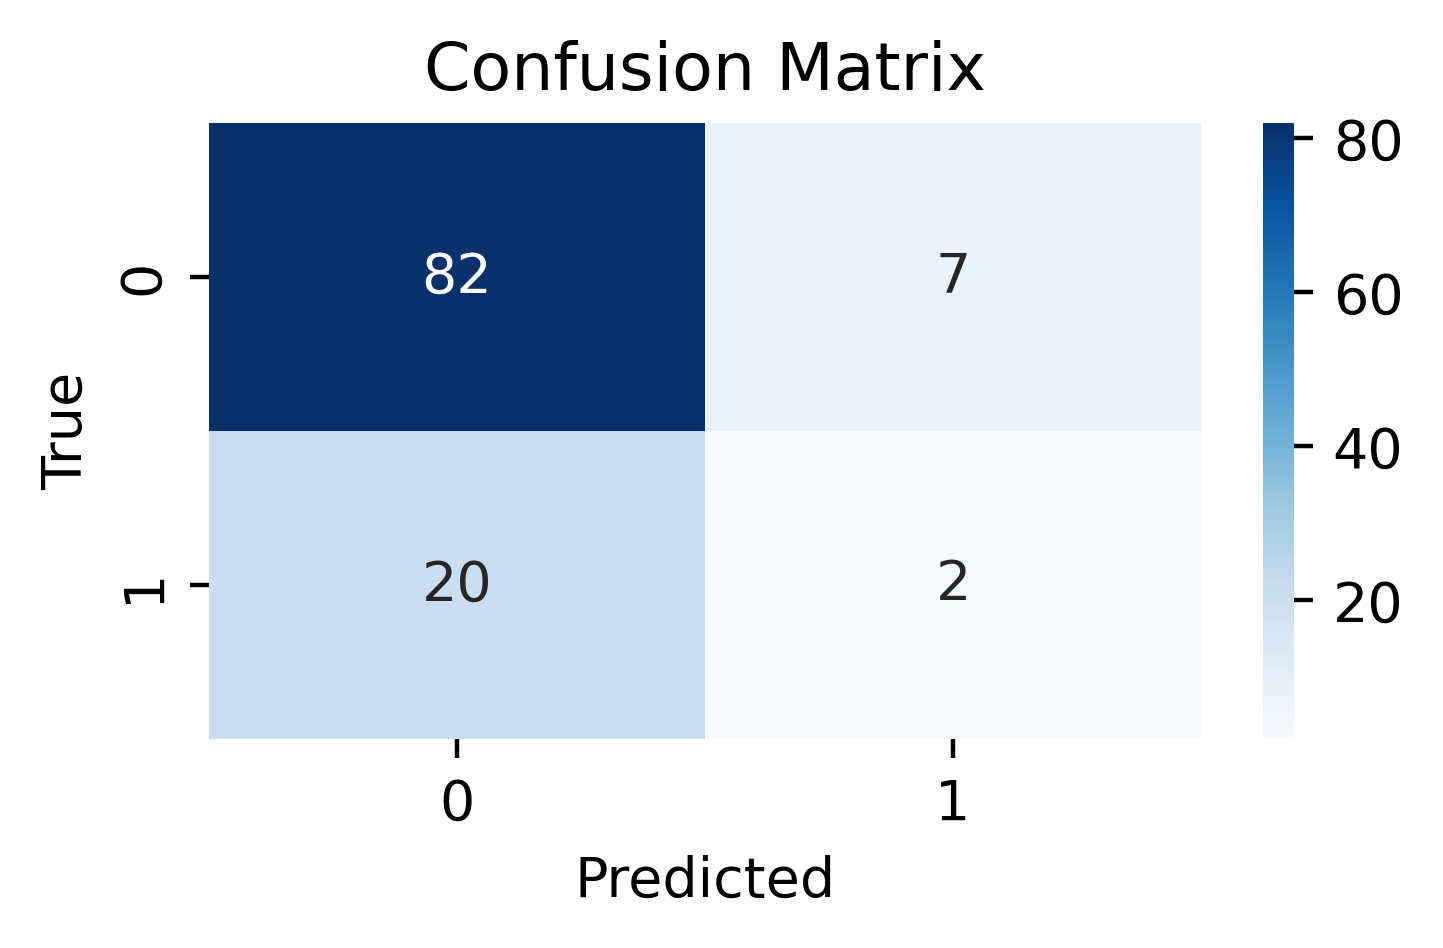

,weighted_avg_f1,macro_avg_f1,true_f1_score,accuracy,MCC,model_run
RF,0.714032,0.493836,0.129032,0.756757,0.017901,b3_ml_static


In [17]:
fts_for_b3_rf_static = [
    "month_bin",
    "diet_milk",
    "diet_weaning",
    "delivery_mode",
    "div_alpha_faith_pd",
]

df_results_b3_rf_static = train_n_evaluate_rf_model(
    "true_target",
    fts_for_b3_rf_static,
    unsupervised_subset,
    stratify_split=stratify_by_host,
)
df_results_b3_rf_static["model_run"] = "b3_ml_static"
df_results_b3_rf_static

### B3: RF-based classifier: semi-static

              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        89
         1.0       0.22      0.09      0.13        22

    accuracy                           0.76       111
   macro avg       0.51      0.51      0.49       111
weighted avg       0.69      0.76      0.71       111



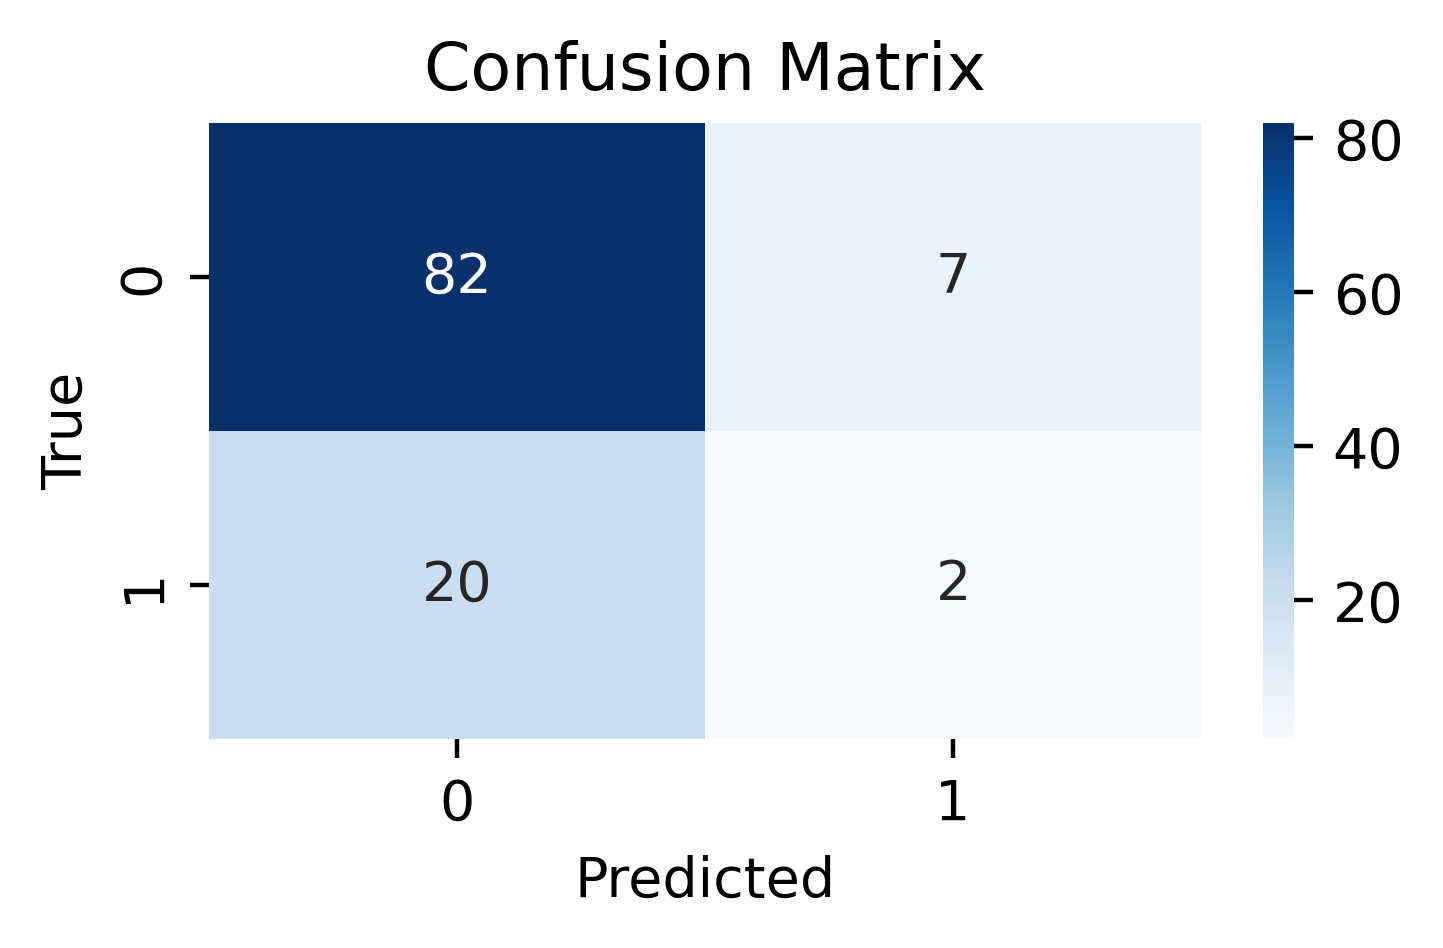

,weighted_avg_f1,macro_avg_f1,true_f1_score,accuracy,MCC,model_run
RF,0.714032,0.493836,0.129032,0.756757,0.017901,b3_ml_semi_static


In [18]:
fts_for_b3_rf_semi_static = [
    "month_bin",
    "diet_milk",
    "diet_weaning",
    "delivery_mode",
    "div_alpha_faith_pd",
    "div_alpha_faith_pd_before",
]

df_results_b3_rf_semi_static = train_n_evaluate_rf_model(
    "true_target",
    fts_for_b3_rf_semi_static,
    unsupervised_subset,
    stratify_split=stratify_by_host,
)
df_results_b3_rf_semi_static["model_run"] = "b3_ml_semi_static"
df_results_b3_rf_semi_static

## Merge all results into one dataframe and save

In [19]:
df_results_all = pd.concat(
    [
        df_results_absolute,
        df_results_relative,
        df_results_ml,
        df_results_b1_absolute,
        df_results_b2_relative,
        df_results_b3_rf_static,
        df_results_b3_rf_semi_static,
    ]
)
df_results_all.reset_index(inplace=True, names=["hyperparams"])
df_results_all.to_csv(f"{evaluation_path}all_results.csv")

select per "model_run" the row with the largest "macro_avg_f1" value:

In [20]:
# Get the best models per 'model_run'
df_best_models = df_results_all.loc[
    df_results_all.groupby("model_run")["macro_avg_f1"].idxmax()
]
df_best_models = df_best_models.sort_values(by="macro_avg_f1", ascending=False)

# Reorder the columns
df_best_models = df_best_models[
    [
        "model_run",
        "hyperparams",
        "macro_avg_f1",
        "MCC",
        "true_f1_score",
        "weighted_avg_f1",
        "accuracy",
    ]
]

# Round numerical columns to 3 decimal places
numeric_cols = ["macro_avg_f1", "MCC", "true_f1_score", "weighted_avg_f1", "accuracy"]
df_best_models[numeric_cols] = df_best_models[numeric_cols].round(3)
df_best_models.set_index("model_run", inplace=True)

df_best_models.to_csv(f"{evaluation_path}best_results.csv")

df_best_models

,hyperparams,macro_avg_f1,MCC,true_f1_score,weighted_avg_f1,accuracy
model_run,,,,,,
s1_absolute,0.8,0.558,0.120,0.333,0.683,0.672
s3_ml,RF,0.530,0.061,0.238,0.706,0.712
b1_absolute,7.0,0.496,0.018,0.155,0.686,0.726
b3_ml_static,RF,0.494,0.018,0.129,0.714,0.757
b3_ml_semi_static,RF,0.494,0.018,0.129,0.714,0.757
s2_relative,2.0,0.491,-0.016,0.188,0.660,0.672
b2_relative,1.4,0.472,-0.051,0.148,0.653,0.672
